In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp
from scipy.optimize import curve_fit
import os
from matplotlib.collections import LineCollection
import matplotlib.animation as animation

In [ ]:
os.chdir('/content/drive/MyDrive/Tesis/Data')

In [ ]:
os.chdir('/content/drive/MyDrive/Tesis/Data2')

In [ ]:
os.chdir('/content/drive/MyDrive/Tesis/Data3')

In [ ]:
os.chdir('/content/drive/MyDrive/Tesis')

# Parallel Functions

In [2]:
forces = cp.ElementwiseKernel(
    'raw float64 X, raw float64 Y, raw float64 params,raw float64 beta,raw float64 gamma, int16 L' ,
    'float64 fX,float64 fY',
    '''
    double N = params[0]; double nu = params[1]; double mu = params[2]; double Dx = params[3]; double Dy = params[4];
    
    int x = i % L;
    int y = (int) i/L;

    fX =  nu - beta[i]*X[i]*Y[i]/N - mu*X[i] + Dx*(X[(x+1)%L + L*y] + X[(x-1+L)%L+L*y] + X[x + L*((y+1)%L)] + X[x + L*((y-1+L)%L)] - 4*X[i]);
    fY = beta[i]*X[i]*Y[i]/N - (gamma[i]+mu)*Y[i] + Dy*(Y[(x+1)%L + L*y] + Y[(x-1+L)%L+L*y] + Y[x + L*((y+1)%L)] + Y[x + L*((y-1+L)%L)] - 4*Y[i]);
    ''',
    'forces')

smoth = cp.ElementwiseKernel(
    'int16 L, raw float64 X', 'float64 Y',
    '''
    int x = i % L;
    int y = (int) i/L;

    Y = (X[(x+1)%L + L*y] + X[(x-1+L)%L+L*y] + X[x + L*((y+1)%L)] + X[x + L*((y-1+L)%L)] + X[i])/5;
    ''','smoth')

euler = cp.ElementwiseKernel(
    'float64 f,float64 X,float64 tstep', 'float64 Y', '''Y = X + tstep*f''','euler')

def smothing(X,n):
  for i in range(n):
    smoth(cp.asnumpy(cp.shape(X))[1],X,X) 
  return X

def dic_smothing(X,n):
  for i in range(n):
    smoth(cp.asnumpy(cp.shape(X))[1],X,X)
  X_mean = cp.mean(X)
  X[X > X_mean] = 1
  X[X < X_mean] = 0

def scan(p_vec,n_vec,flag='',flag2='',gamma0=.2,beta0=1.):
  for j in n_vec:
    for p in tqdm(p_vec):
      X,Y,pos,max,width,fft,q,f,beta,time = solver(gamma0=gamma0,beta0=beta0,p_beta = p, smoth_steps=j,beta_type=flag)
      cp.save('u_cm_'+ str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,pos)
      cp.save('Y_max_' + str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,max)
      cp.save('width_' + str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,width)
      cp.save('fft_' + str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,fft)
      cp.save('q_' + str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,q)
      cp.save('time_' + str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,time)
      cp.save('f_' + str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,f)
      cp.save('beta_'+str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,beta)
      cp.save('X_'+str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,X)
      cp.save('Y_'+str(j)+ '_' + str(p) + '_' + flag+ '_' + flag2,Y)  
    np.save('p_vec'+str(j)+'_'+flag + '_' + flag2,p_vec)

def makeI_gif(Lx=1024,Ly=1024,N=1,nu=0.,mu=0.,Dx=0,Dy=1,beta0=1.,gamma0=.2,p_beta=0,p_gamma=0,tstep=.1,smoth_steps=0,beta_type='',t_max = 50000,flag=''):
  
  def line_infection(x):
    X[:,x] = cp.zeros_like(X[:,x])
    Y[:,x] = cp.ones_like(Y[:,x])
  def u():
    return cp.argmax(Y,axis=1)
  def u_cm():
    return cp.mean(u())
  def dic_matrix(x0,x1,p,Lx,Ly):
    return cp.random.choice([x0,x1],size=(Ly,Lx),p = [p,1-p])
  def rigid_x():
    X[:,0] = X[:,-1] = Y[:,0] = Y[:,-1] = 0
  
  fig,ax = plt.subplots(figsize=(12,8))
  plt.xticks([])
  plt.yticks([])


  beta = dic_matrix(0,beta0,p_beta,Lx,Ly)
  if beta_type =='dic_smoth':
    dic_smothing(beta,smoth_steps)
  if beta_type =='smoth':
    smothing(beta,smoth_steps)
  gamma = dic_matrix(0,gamma0,p_gamma,Lx,Ly)
  params = cp.array([N,nu,mu,Dx,Dy])

  # Condición inicial
  X = cp.ones((Ly,Lx))
  Y = cp.zeros((Ly,Lx))
  line_infection(1)
  Y0 = Y
  
  pos = cp.array([u_cm()])
  #Y_max = cp.array([mean_Ymax()])
  #width = cp.array([u_sigma()]) 
  fX = cp.zeros((Ly,Lx))
  fY = cp.zeros((Ly,Lx))
  #fft = cp.zeros_like(u_fft())
  #fI = cp.zeros_like(f_I())
  t = 0
  tsteps = 0
  im = ax.matshow(cp.asnumpy(Y),cmap='hot')
  txt = plt.text(0.5, 1.01,0, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
  ims = [[im,txt]]
  
  #meansteps = 0

  while (pos[tsteps] < Lx*.8 and tsteps < t_max):
    
    forces(X,Y,params,beta,gamma,Lx,fX,fY)
    X = X + tstep*fX
    Y = Y + tstep*fY
    rigid_x()

    pos = cp.append(pos,u_cm())
    tsteps += 1
    t += tstep 
    im = ax.matshow(cp.asnumpy(Y),cmap='hot')
    ax.axis('off')
    txt = plt.text(0.5, 1.01,'t = ' + str(t), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    ims.append([im,txt])

  anim = animation.ArtistAnimation(fig,ims,blit=True,interval=20,repeat_delay=1000)
  return anim

def solver(Lx=1024,Ly=1024,N=1,nu=0.,mu=0.,Dx=0,Dy=1,beta0=1.,gamma0=.2,p_beta=0,p_gamma=0,tstep=.1,smoth_steps=0,beta_type='',t_max = 50000):

  def line_infection(x):
    X[:,x] = cp.zeros_like(X[:,x])
    Y[:,x] = cp.ones_like(Y[:,x])

  def rigid_x():
    X[:,0] = X[:,-1] = Y[:,0] = Y[:,-1] = 0

  def rigid_y():
    X[0,:] = X[-1,:] = Y[0,:] = Y[-1,:] = 0
  
  def point_infection(x0,y0):
    X[y0,x0] = 0
    Y[y0,x0] = 1 
  
  def u():
    return cp.argmax(Y,axis=1)

  def u_cm():
    return cp.mean(u())
  
  def u_sigma():
    return np.std(u())

  def u_fft():
    return cp.square(cp.abs(cp.fft.fft(u())))
  
  def f_I():
    return cp.roll(np.mean(Y,axis=0),int(-u_cm())+Lx//2)
  
  def dic_matrix(x0,x1,p,Lx,Ly):
    return cp.random.choice([x0,x1],size=(Ly,Lx),p = [p,1-p])
  
  def mean_Ymax():
    return cp.mean(cp.max(Y,axis=1))

  # Heterogeneidad
  beta = dic_matrix(0,beta0,p_beta,Lx,Ly)
  if beta_type =='dic_smoth':
    dic_smothing(beta,smoth_steps)
  if beta_type =='smoth':
    smothing(beta,smoth_steps)
  gamma = dic_matrix(0,gamma0,p_gamma,Lx,Ly)
  params = cp.array([N,nu,mu,Dx,Dy])

  # Condición inicial
  X = cp.ones((Ly,Lx))
  Y = cp.zeros((Ly,Lx))
  line_infection(1)
  
  pos = cp.array([u_cm()])
  Y_max = cp.array([mean_Ymax()])
  width = cp.array([u_sigma()]) 
  fX = cp.zeros((Ly,Lx))
  fY = cp.zeros((Ly,Lx))
  fft = cp.zeros_like(u_fft())
  fI = cp.zeros_like(f_I())

  tsteps = 0
  meansteps = 0

  while (pos[tsteps] < Lx*.8 and tsteps < t_max):
    
    forces(X,Y,params,beta,gamma,Lx,fX,fY)
    X = X + tstep*fX
    Y = Y + tstep*fY 
 
    #Bordes rígidos
    rigid_x()
    #rigid_y()

    pos = cp.append(pos,u_cm())
    Y_max = cp.append(Y_max,mean_Ymax())
    width = cp.append(width,u_sigma())
    if pos[tsteps]>100:
      fft += u_fft()
      fI += f_I()
      meansteps += 1
    
    tsteps += 1
  
  fft = fft/meansteps
  q = cp.fft.fftfreq(Ly)
  fI = fI/meansteps
  time = cp.arange(len(pos))*tstep
  

  return  X,Y,pos,Y_max,width,fft[:len(fft)//2],q[:len(fft)//2],fI,beta,time

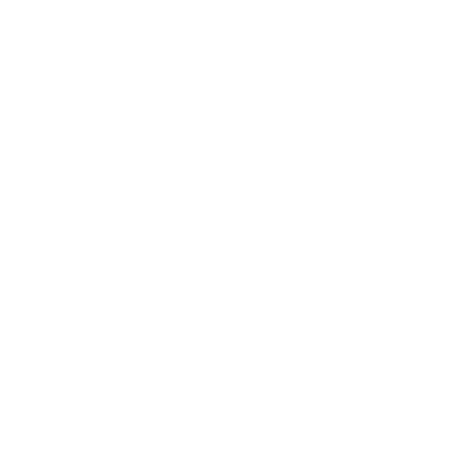

In [ ]:
anim = makeI_gif(Lx = 300,Ly = 300,p_beta = .7,t_max=2000)

In [ ]:
writervideo = animation.FFMpegWriter(fps=80) 
anim.save('/content/drive/MyDrive/Tesis/DA_p_0.7.mp4',writer=writervideo)

In [ ]:
anim.save('/content/drive/MyDrive/Tesis/DA_p_0.7.gif', writer='pillow', fps=60)

# Regular Functions

In [ ]:
def dic_matrix(x0,x1,p,Lx,Ly):
  return np.random.choice([x0,x1],size=(Ly,Lx),p = [p,1-p])

def f_I_front(x,beta=1.,gamma=.2,D=1.,S0=1):
  return np.exp(-c_0(beta,gamma,D)/(2*D)*x)

def f_I_back(x,S1=0,beta=1,gamma=.2,D=1,S0=1):
  return np.exp((-c_0(beta,gamma,D,S0)/(2*D)+np.sqrt(beta/D*(S0-S1)))*x)

def u(Y):
  return np.argmax(Y,axis=1)

def c_0(beta=1,gamma=.2,D=1.,S0=1.):
  return 2*np.sqrt(D*beta*(S0-gamma/beta))

def wave_form(Y):
  return np.mean(Y,axis=0)

def lineal(x,a,b):
  return a*x + b

def sqrt_root(x,a,b):
  return a*np.sqrt(1-x/b)

def root(x,a,b,c):
  return a*(1-x/b)**c

def velocity(t,x):
    fit, cov = curve_fit(lineal,t,x)
    return fit[0]

def plot_scan(p_vec,n,x,y,flag='',flag2='',cbar=False):
  fig, ax = plt.subplots(figsize=(12,8))
  xs = [np.load(x + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy') for p in p_vec]
  ys = [np.load(y + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy') for p in p_vec]
  line_segments = LineCollection([np.column_stack([x, y]) for x,y in zip(xs,ys)],cmap='copper')
  line_segments.set_array(p_vec)
  ax.add_collection(line_segments)
  if cbar:
    axcb = fig.colorbar(line_segments)
    axcb.set_label('$p$',fontsize=16)
  ax.autoscale()
  return fig,ax

def plot_beta_scan(p_vec,n,x,y,flag='',flag2='',cbar=False):
  fig, ax = plt.subplots(figsize=(12,8))
  xs = [np.load(x + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy') for p in p_vec]
  ys = [np.load(y + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy') for p in p_vec]
  beta_mean = np.array([np.mean(np.load('beta_' + str(n)+'_'+str(p)+'_'+flag+'_'+ flag2+'.npy')) for p in p_vec])
  line_segments = LineCollection([np.column_stack([x, y]) for x,y in zip(xs,ys)],cmap='copper')
  line_segments.set_array(beta_mean)
  ax.add_collection(line_segments)
  if cbar:
    axcb = fig.colorbar(line_segments)
    axcb.set_label(r'$\overline{\beta}$',fontsize=16,rotation=0,labelpad=10)
  ax.autoscale()

def fp_scan(p_vec,n,flag='',flag2='',cbar=False):
  fig, ax = plt.subplots(figsize=(14,8))
  ys = [np.load('f_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy') for p in p_vec]
  x = np.arange(len(ys[0]))
  line_segments = LineCollection([np.column_stack([x, y]) for y in ys],cmap='copper')
  line_segments.set_array(p_vec)
  ax.add_collection(line_segments)
  if cbar:
    axcb = fig.colorbar(line_segments)
    axcb.set_label('$p$',fontsize=16)
  ax.autoscale()

def fbeta_scan(p_vec,n,flag='',flag2='',cbar=False):
  fig, ax = plt.subplots(figsize=(14,8))
  ys = [np.load('f_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy') for p in p_vec]
  x = np.arange(len(ys[0]))
  beta_mean = np.array([np.mean(np.load('beta_' + str(n)+'_'+str(p)+'_'+flag+'_'+ flag2+'.npy')) for p in p_vec])
  line_segments = LineCollection([np.column_stack([x, y]) for y in ys],cmap='copper')
  line_segments.set_array(beta_mean)
  ax.add_collection(line_segments)
  if cbar:
    axcb = fig.colorbar(line_segments)
    axcb.set_label(r'$\overline{\beta}$',fontsize=16)
  ax.autoscale()


def cp_scan(p_vec,n,flag='',flag2=''):
  pc = np.array([])
  c = np.array([])
  c_err = np.array([])
  for p in p_vec:
    time = np.load('time_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy')
    pos = np.load('u_cm_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2 + '.npy')
    w = np.load('width_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy')
    if w[-1]<100 and pos[-1]>400:
      fit,cov = curve_fit(lineal,time[pos>400],pos[pos>400])
      if fit[0] > .01:
        pc = np.append(pc,p)
        c = np.append(c,fit[0])
        c_err = np.append(c_err,cov[0,0]) 
  return pc,c,c_err

def cn_scan(p,n_vec,flag='',flag2=''): 
  c = np.array([])
  c_err = np.array([])
  for j in n_vec:
    time = np.load('time_' + str(j)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy')
    pos = np.load('u_cm_' + str(j)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy')
    c_,cov_ = curve_fit(lineal,time[pos>50],pos[pos>50])
    c = np.append(c,c_)
    c_err = np.append(cov_,cov_[0,0]) 
  return c,c_err

def Yp_scan(p_vec,n,flag='',flag2=''):
    Y = np.array([])
    pc = np.array([])
    for p in p_vec:
      Ymax = np.load('Y_max_'+str(n)+'_'+str(p)+'_'+flag+'_'+flag2+'.npy')
      pos = np.load('u_cm_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2 + '.npy')
      w = np.load('width_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy')
      if w[-1]<50:
        Y = np.append(Y,np.mean(Ymax[pos>400]))
        pc = np.append(pc,p)
    return pc,Y

def fftp_scan(p_vec,n,flag='',flag2=''):
  fig, ax = plt.subplots(figsize=(14,8))
  xs = [np.load('q_' + str(n) + '_' + str(p) + '_' + flag+ '_' + flag2+'.npy') for p in p_vec]
  ys = [np.load('fft_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy') for p in p_vec]
  
  line_segments = LineCollection([np.column_stack([x, y]) for x,y in zip(xs,ys)],cmap='copper')
  
  line_segments.set_array(p_vec)
  ax.add_collection(line_segments)
  ax.set_xlim(.007,.5)
  plt.loglog()
  axcb = fig.colorbar(line_segments)
  axcb.set_label('$p$',fontsize=16)

def fftbeta_scan(p_vec,n,flag='',flag2=''):
  fig, ax = plt.subplots(figsize=(14,8))
  xs = [np.load('q_' + str(n) + '_' + str(p) + '_' + flag+ '_' + flag2+'.npy') for p in p_vec]
  ys = [np.load('fft_' + str(n)+ '_' + str(p) + '_' +flag+ '_' + flag2+'.npy') for p in p_vec]
  line_segments = LineCollection([np.column_stack([x, y]) for x,y in zip(xs,ys)],cmap='copper')
  beta_mean = np.array([np.mean(np.load('beta_' + str(n)+'_'+str(p)+'_'+flag+'_'+ flag2+'.npy')) for p in p_vec])  
  line_segments.set_array(beta_mean)
  ax.add_collection(line_segments)
  ax.set_xlim(.007,.5)
  plt.loglog()
  axcb = fig.colorbar(line_segments)
  axcb.set_label(r'$\overline{\beta}$',fontsize=16)


# Results


In [ ]:
ni = 20;nf = 100;dn = 10
pi = 0;pf = .8 ;n0 = 100
p_vec = np.arange(pi,pf,(pf-pi)/n0)
n_vec = np.arange(ni,nf,dn)
betas = 1-p_vec
for beta in tqdm(betas):
  scan([0],[0],beta0=beta,flag='hom_'+str(beta))

100%|██████████| 100/100 [48:33<00:00, 29.14s/it] 


In [ ]:
ni = 20;nf = 100;dn = 10
pi = 0;pf = 1 ;n0 = 100
p_vec = np.arange(pi,pf,(pf-pi)/n0)
n_vec = np.arange(ni,nf,dn)
scan(p_vec,[1],flag='dic_smoth')


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/cupy/fft/_fft.py:152: UserWarning:

cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.

100%|██████████| 100/100 [40:01<00:00, 24.01s/it]


## Regular and Dichotomic Smoth (n=1)

In [ ]:
ni = 0;nf = 2;dn = 1
pi = 0;pf = .9;n0 = 100
p_vec = np.arange(pi,pf,(pf-pi)/n0)
p_vec2 = np.arange(.9,1,.1/50)
n_vec = np.arange(ni,nf,dn)
p_vec_dic = np.append(p_vec,p_vec2)
plt.style.use('ggplot')

Text(0.5, 1.0, 'Suavizado dicotómico')

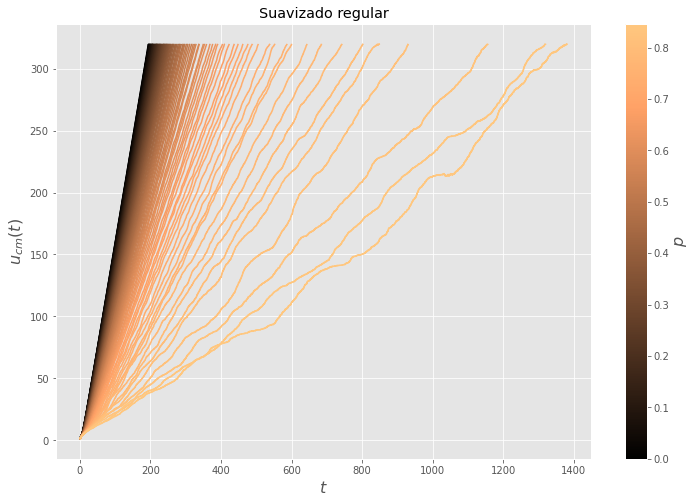

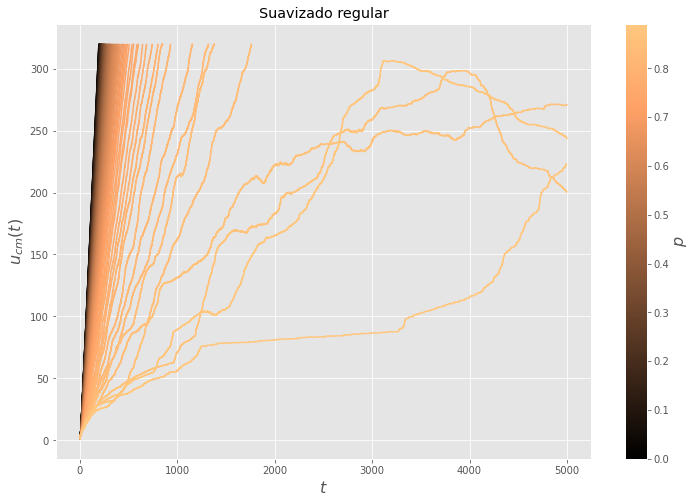

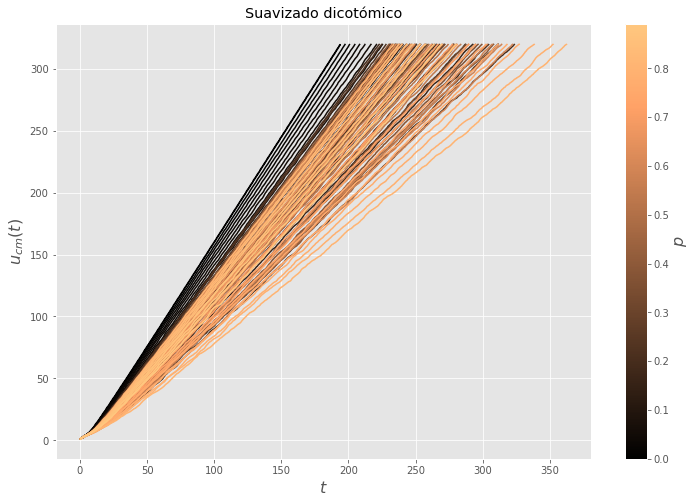

In [ ]:
plot_scan(p_vec[p_vec<.85],1,'time_','u_cm_',flag='smoth',cbar=True)
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$u_{cm}(t)$',fontsize=16)
plt.title('Suavizado regular')

plot_scan(p_vec,1,'time_','u_cm_',flag='smoth',cbar=True)
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$u_{cm}(t)$',fontsize=16)
plt.title('Suavizado regular')

plot_scan(p_vec,1,'time_','u_cm_',flag='dic_smoth',cbar=True)
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$u_{cm}(t)$',fontsize=16)
plt.title('Suavizado dicotómico')

Text(0.5, 1.0, 'Suavizado dicotómico')

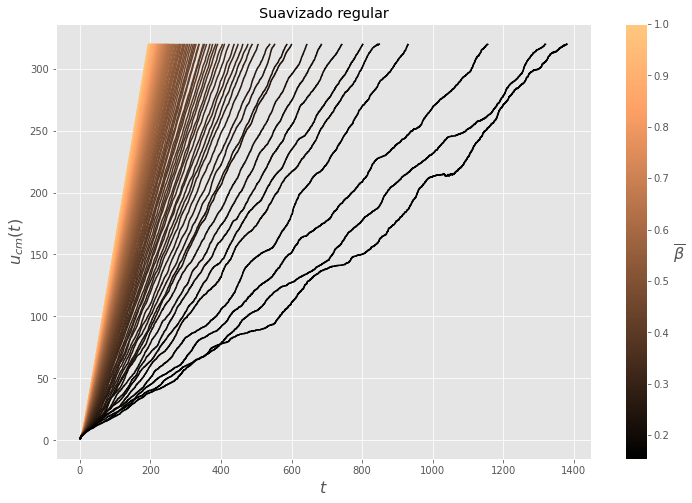

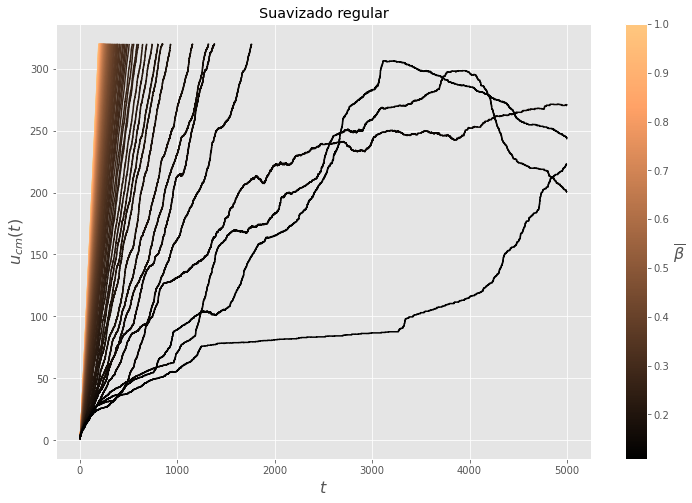

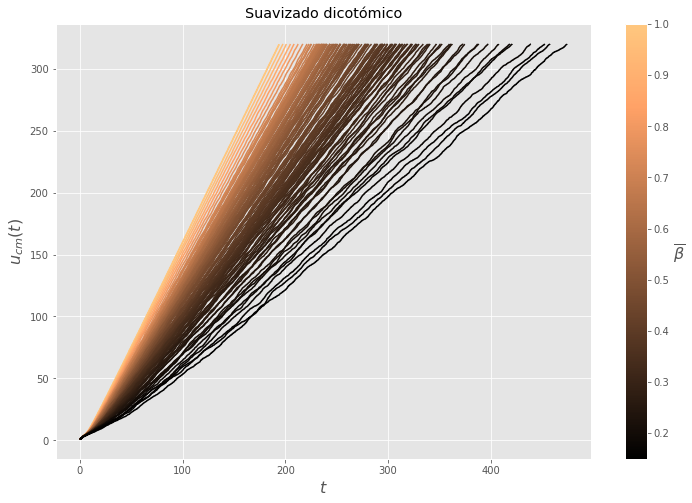

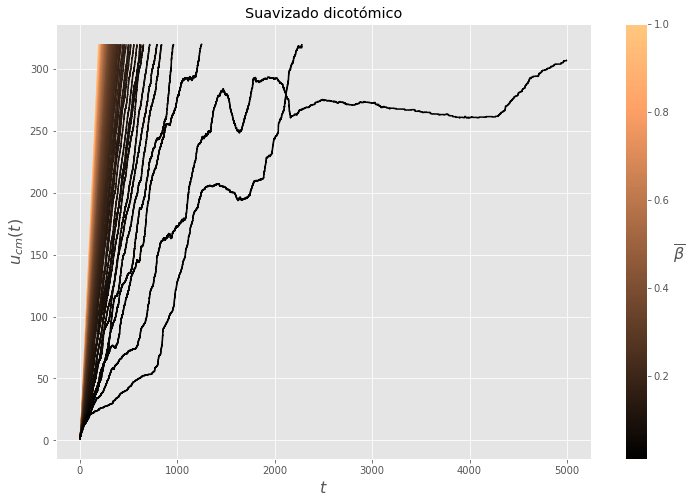

In [ ]:
plot_beta_scan(p_vec[p_vec<.85],1,'time_','u_cm_',flag='smoth',cbar=True)
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$u_{cm}(t)$',fontsize=16)
plt.title('Suavizado regular')

plot_beta_scan(p_vec,1,'time_','u_cm_',flag='smoth',cbar=True)
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$u_{cm}(t)$',fontsize=16)
plt.title('Suavizado regular')

p_vec_dic = np.append(p_vec,p_vec2)
plot_beta_scan(p_vec_dic[p_vec_dic<.97],1,'time_','u_cm_',flag='dic_smoth',cbar=True)
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$u_{cm}(t)$',fontsize=16)
plt.title('Suavizado dicotómico')

p_vec_dic = np.append(p_vec,p_vec2)
plot_beta_scan(p_vec_dic,1,'time_','u_cm_',flag='dic_smoth',cbar=True)
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$u_{cm}(t)$',fontsize=16)
plt.title('Suavizado dicotómico')

Text(0.5, 1.0, 'Suavizado dicotómico')

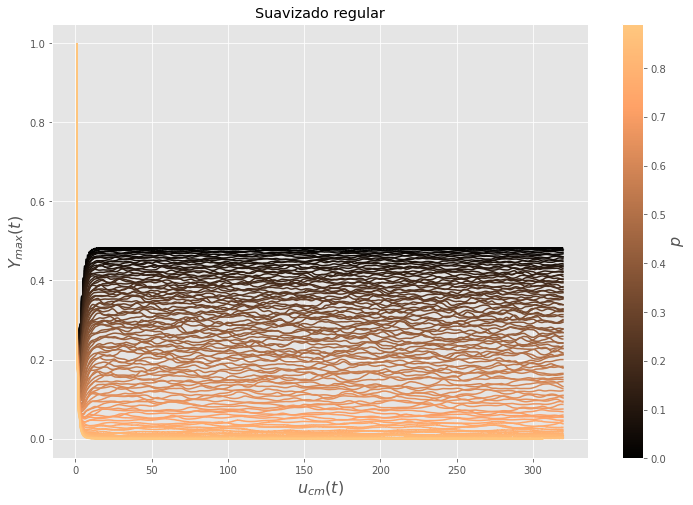

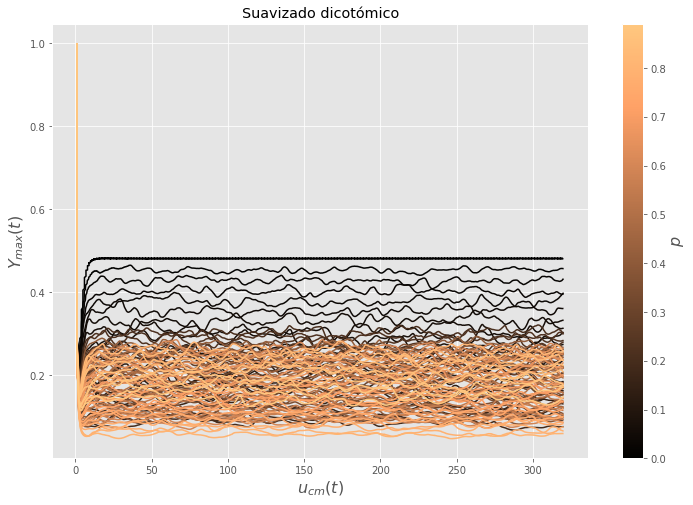

In [ ]:
plot_scan(p_vec,1,'u_cm_','Y_max_',flag='smoth',cbar=True)
plt.xlabel('$u_{cm}(t)$',fontsize=16)
plt.ylabel('$Y_{max}(t)$',fontsize=16)
plt.title('Suavizado regular')

plot_scan(p_vec,1,'u_cm_','Y_max_',flag='dic_smoth',cbar=True)
plt.xlabel('$u_{cm}(t)$',fontsize=16)
plt.ylabel('$Y_{max}(t)$',fontsize=16)
plt.title('Suavizado dicotómico')

Text(0.5, 1.0, 'Suavizado dicotómico')

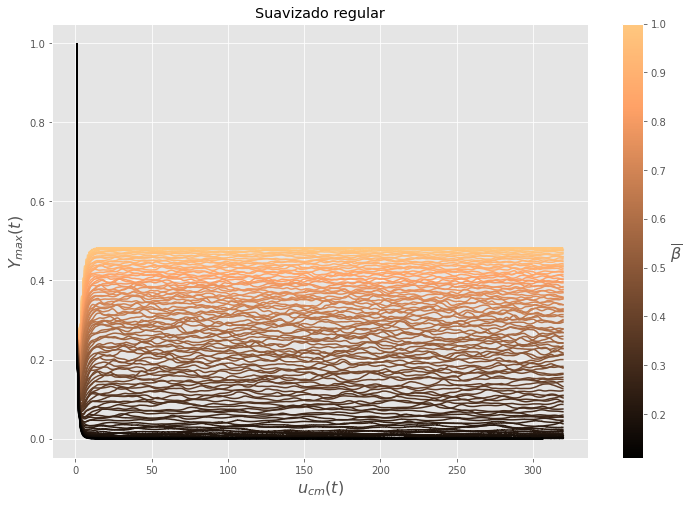

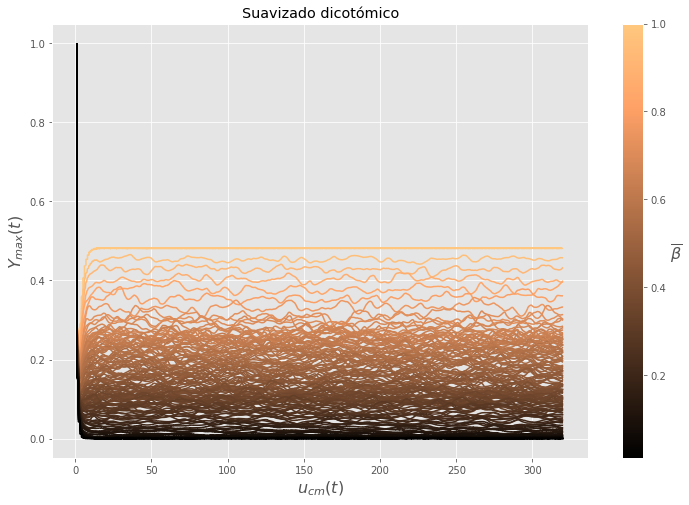

In [ ]:
plot_beta_scan(p_vec,1,'u_cm_','Y_max_',flag='smoth',cbar=True)
plt.xlabel('$u_{cm}(t)$',fontsize=16)
plt.ylabel('$Y_{max}(t)$',fontsize=16)
plt.title('Suavizado regular')

plot_beta_scan(p_vec_dic,1,'u_cm_','Y_max_',flag='dic_smoth',cbar=True)
plt.xlabel('$u_{cm}(t)$',fontsize=16)
plt.ylabel('$Y_{max}(t)$',fontsize=16)
plt.title('Suavizado dicotómico')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in power



[1.71572496 0.89574885 0.46165561]
[[7.77553880e-06 6.81632879e-07 5.46822305e-06]
 [6.81632879e-07 6.95293657e-07 1.51658761e-06]
 [5.46822305e-06 1.51658761e-06 7.81395991e-06]]
[1.74004984 0.89101414 0.56771269]
[[6.91437437e-05 8.48610650e-08 4.26015419e-05]
 [8.48610650e-08 9.42986705e-08 2.18332901e-07]
 [4.26015419e-05 2.18332901e-07 5.31153940e-05]]
[1.72441759 0.84615085 0.54367946]
[[2.65521298e-05 1.86631140e-07 1.64295006e-05]
 [1.86631140e-07 1.82814697e-07 4.54931382e-07]
 [1.64295006e-05 4.54931382e-07 2.06755170e-05]]
1.7888543819998317


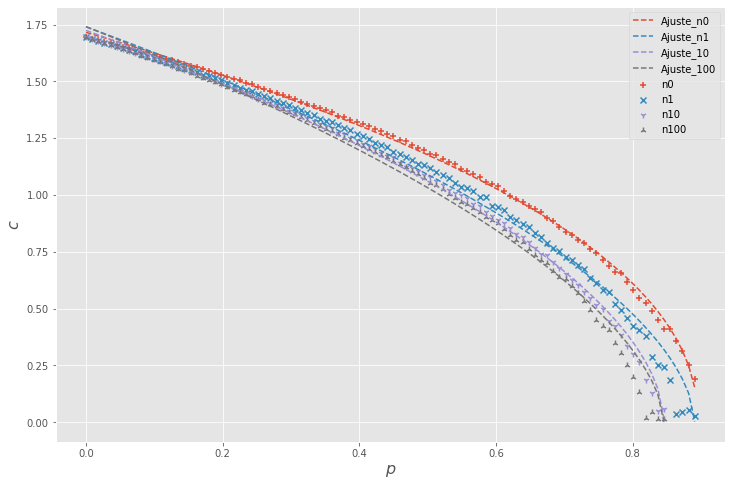

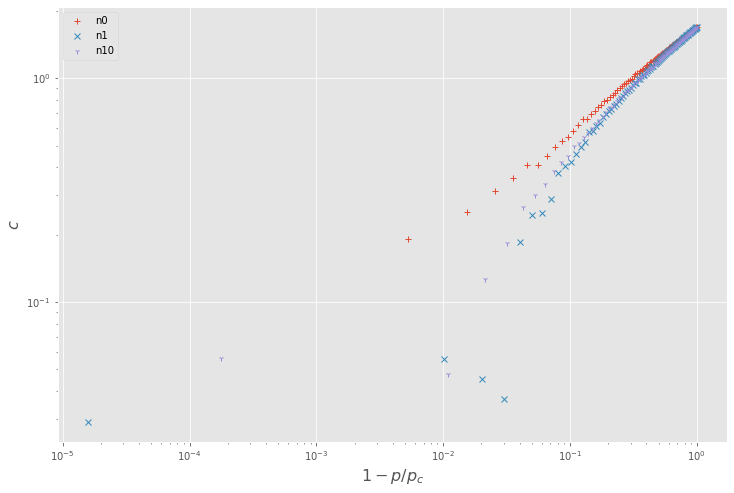

In [ ]:
plt.figure(figsize=(12,8))
c0,c0_err = cp_scan(p_vec,0,flag='smoth')
c1,c1_err = cp_scan(p_vec,1,flag='smoth')
c10,c10_err = cp_scan(p_vec[p_vec<.85],10,flag='smoth')
c100,c100_err = cp_scan(p_vec[p_vec<.85],100,flag='smoth')

fit0,cov0 = curve_fit(root,p_vec,c0)  
fit1,cov1 = curve_fit(root,p_vec,c1)
fit10,cov10 = curve_fit(root,p_vec[p_vec<.85],c10)
fit100,cov100 = curve_fit(root,p_vec[p_vec<.85],c100)

plt.scatter(p_vec,c0,label='n0',marker='+')
plt.scatter(p_vec,c1,label='n1',marker='x')
plt.scatter(p_vec[p_vec<.85],c10,label='n10',marker='1')
plt.scatter(p_vec[p_vec<.85],c100,label='n100',marker='2')

plt.plot(p_vec,root(p_vec,*fit0),'--',label='Ajuste_n0')
plt.plot(p_vec,root(p_vec,*fit1),'--',label='Ajuste_n1')
plt.plot(p_vec[p_vec<.85],root(p_vec[p_vec<.85],*fit10),'--',label='Ajuste_10')
plt.plot(p_vec[p_vec<.85],root(p_vec[p_vec<.85],*fit100),'--',label='Ajuste_100')

plt.xlabel('$p$',fontsize=16)
plt.ylabel('$c$',fontsize=16)
plt.legend()

plt.figure(figsize=(12,8))
plt.loglog(1-p_vec/fit0[1],c0,' ',label='n0',marker='+')
plt.loglog(1-p_vec/fit1[1],c1,' ',label='n1',marker='x')
plt.loglog(1-p_vec[p_vec<.85]/fit10[1],c10,' ',label='n10',marker='1')
plt.xlabel('$1-p/p_c$',fontsize=16)
plt.ylabel('$c$',fontsize=16)
plt.legend()

print(fit0)
print(cov0)
print(fit1)
print(cov1)
print(fit10)
print(cov10)
print(c_0(1,.2,1))

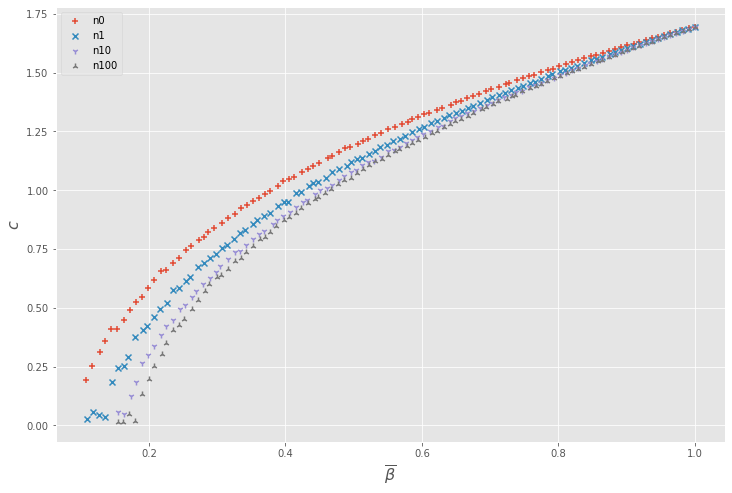

In [ ]:
flag = 'smoth'
beta_mean0 = np.array([np.mean(np.load('beta_' + str(0)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])
beta_mean1 = np.array([np.mean(np.load('beta_' + str(1)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])
beta_mean10 = np.array([np.mean(np.load('beta_' + str(10)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])
beta_mean100 = np.array([np.mean(np.load('beta_' + str(100)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])

plt.figure(figsize=(12,8))
c0,c0_err = cp_scan(p_vec,0,flag='smoth')
c1,c1_err = cp_scan(p_vec,1,flag='smoth')
c10,c10_err = cp_scan(p_vec[p_vec<.85],10,flag='smoth')
c100,c100_err = cp_scan(p_vec[p_vec<.85],100,flag='smoth')

plt.scatter(beta_mean0,c0,label='n0',marker='+')
plt.scatter(beta_mean1,c1,label='n1',marker='x')
plt.scatter(beta_mean10[p_vec<.85],c10,label='n10',marker='1')
plt.scatter(beta_mean100[p_vec<.85],c100,label='n100',marker='2')

plt.xlabel(r'$\overline{\beta}$',fontsize=16)
plt.ylabel('$c$',fontsize=16)
plt.legend()

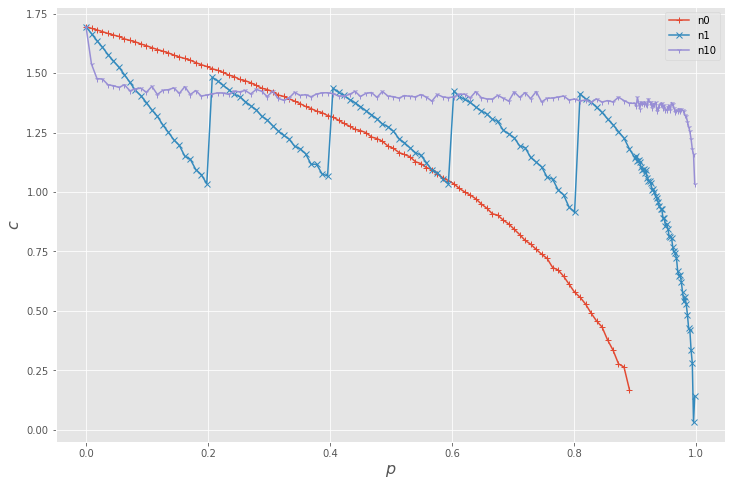

In [ ]:
plt.figure(figsize=(12,8))
c0,c0_err = cp_scan(p_vec,0,flag='dic_smoth')
c1,c1_err = cp_scan(p_vec_dic,1,flag='dic_smoth')
c10,c10_err = cp_scan(p_vec_dic,10,flag='dic_smoth')

plt.plot(p_vec,c0,label='n0',marker='+')
plt.plot(p_vec_dic,c1,label='n1',marker='x')
plt.plot(p_vec_dic,c10,label='n10',marker='1')

plt.xlabel('$p$',fontsize=16)
plt.ylabel('$c$',fontsize=16)
plt.legend()


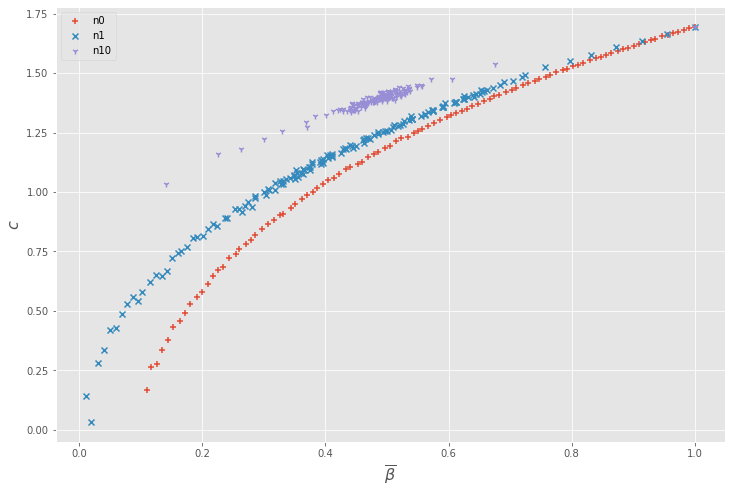

In [ ]:
flag = 'dic_smoth'
beta_mean0 = np.array([np.mean(np.load('beta_' + str(0)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])
beta_mean1 = np.array([np.mean(np.load('beta_' + str(1)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec_dic])
beta_mean10 = np.array([np.mean(np.load('beta_' + str(10)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec_dic])

plt.figure(figsize=(12,8))
c0,c0_err = cp_scan(p_vec,0,flag='dic_smoth')
c1,c1_err = cp_scan(p_vec_dic,1,flag='dic_smoth')
c10,c10_err = cp_scan(p_vec_dic,10,flag='dic_smoth')

plt.scatter(beta_mean0,c0,label='n0',marker='+')
plt.scatter(beta_mean1,c1,label='n1',marker='x')
plt.scatter(beta_mean10,c10,label='n10',marker='1')

plt.xlabel(r'$\overline{\beta}$',fontsize=16)
plt.ylabel('$c$',fontsize=16)
plt.legend()


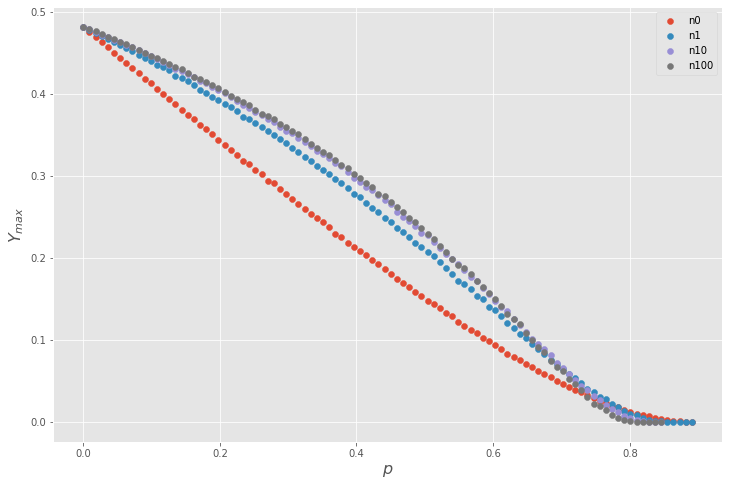

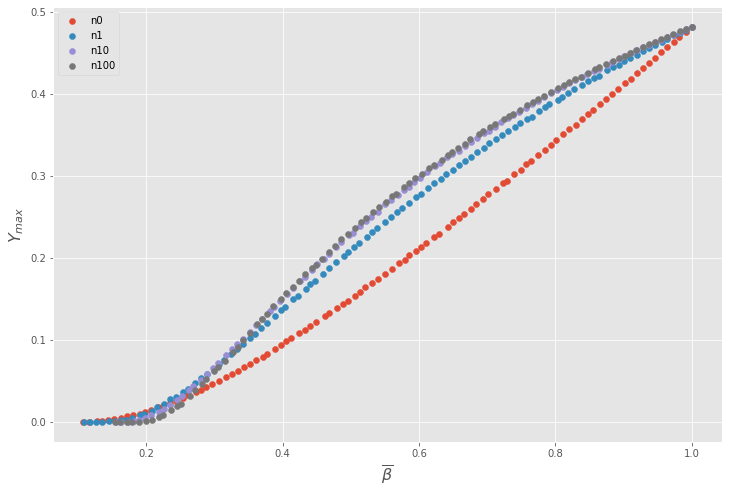

In [ ]:
flag = 'smoth'
Y0 = Yp_scan(p_vec,0,flag='smoth')
Y1 = Yp_scan(p_vec,1,flag='smoth')
Y10 = Yp_scan(p_vec[p_vec<.85],10,flag='smoth')
Y100 = Yp_scan(p_vec[p_vec<.85],100,flag='smoth')
beta_mean0 = np.array([np.mean(np.load('beta_' + str(0)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])
beta_mean1 = np.array([np.mean(np.load('beta_' + str(1)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])
beta_mean10 = np.array([np.mean(np.load('beta_' + str(10)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])
beta_mean100 = np.array([np.mean(np.load('beta_' + str(100)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])

plt.figure(figsize=(12,8))
plt.scatter(p_vec,Y0,label='n0')
plt.scatter(p_vec,Y1,label='n1')
plt.scatter(p_vec[p_vec<.85],Y10,label='n10')
plt.scatter(p_vec[p_vec<.85],Y100,label='n100')

plt.xlabel('$p$',fontsize=16)
plt.ylabel('$Y_{max}$',fontsize=16)
plt.legend()

plt.figure(figsize=(12,8))
plt.scatter(beta_mean0,Y0,label='n0')
plt.scatter(beta_mean1,Y1,label='n1')
plt.scatter(beta_mean10[p_vec<.85],Y10,label='n10')
plt.scatter(beta_mean100[p_vec<.85],Y100,label='n100')

plt.xlabel(r'$\overline{\beta}$',fontsize=16)
plt.ylabel('$Y_{max}$',fontsize=16)
plt.legend()


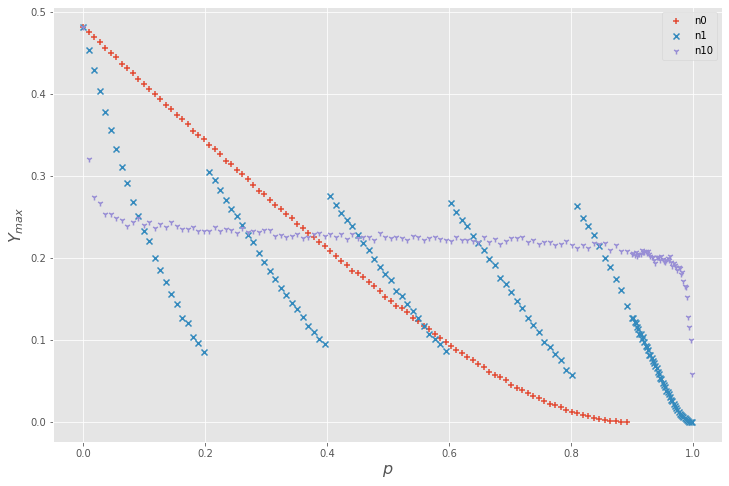

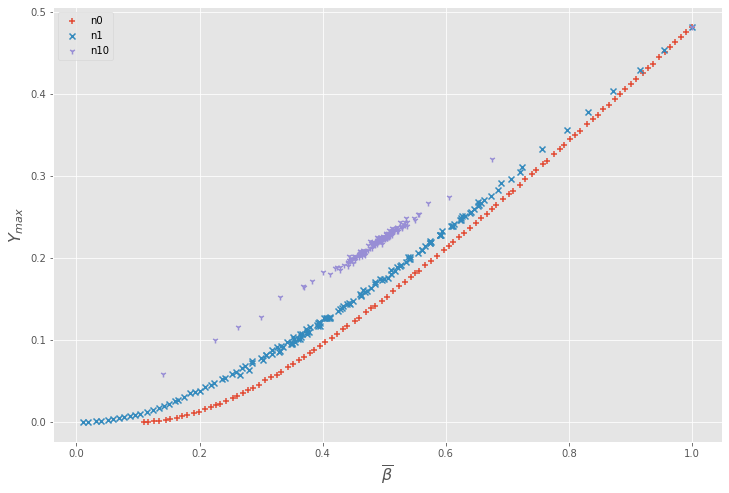

In [ ]:
flag='dic_smoth'
Y0 = Yp_scan(p_vec,0,flag='dic_smoth')
Y1 = Yp_scan(p_vec_dic,1,flag='dic_smoth')
Y10 = Yp_scan(p_vec_dic,10,flag='dic_smoth')
beta_mean0 = np.array([np.mean(np.load('beta_' + str(0)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec])
beta_mean1 = np.array([np.mean(np.load('beta_' + str(1)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec_dic])
beta_mean10 = np.array([np.mean(np.load('beta_' + str(10)+'_'+str(p)+'_'+flag+'_'+'.npy'))for p in p_vec_dic])

plt.figure(figsize=(12,8))
plt.scatter(p_vec,Y0,label='n0',marker='+')
plt.scatter(p_vec_dic,Y1,label='n1',marker='x')
plt.scatter(p_vec_dic,Y10,label='n10',marker='1')

plt.xlabel('$p$',fontsize=16)
plt.ylabel('$Y_{max}$',fontsize=16)
plt.legend()

plt.figure(figsize=(12,8))
plt.scatter(beta_mean0,Y0,label='n0',marker='+')
plt.scatter(beta_mean1,Y1,label='n1',marker='x')
plt.scatter(beta_mean10,Y10,label='n10',marker='1')

plt.xlabel(r'$\overline{\beta}$',fontsize=16)
plt.ylabel('$Y_{max}$',fontsize=16)
plt.legend()

Text(0.5, 1.0, 'Suavizado dicotómico')

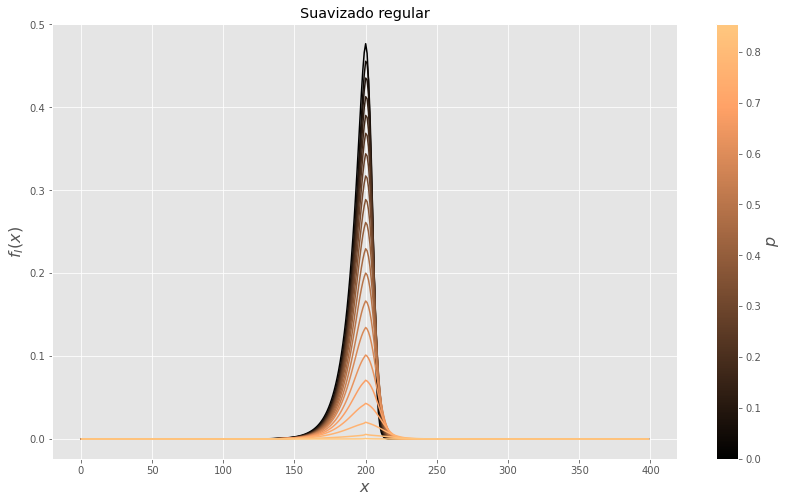

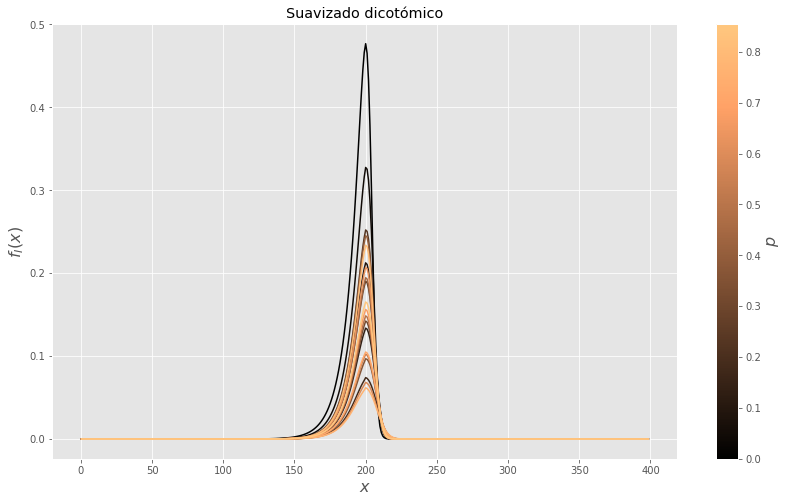

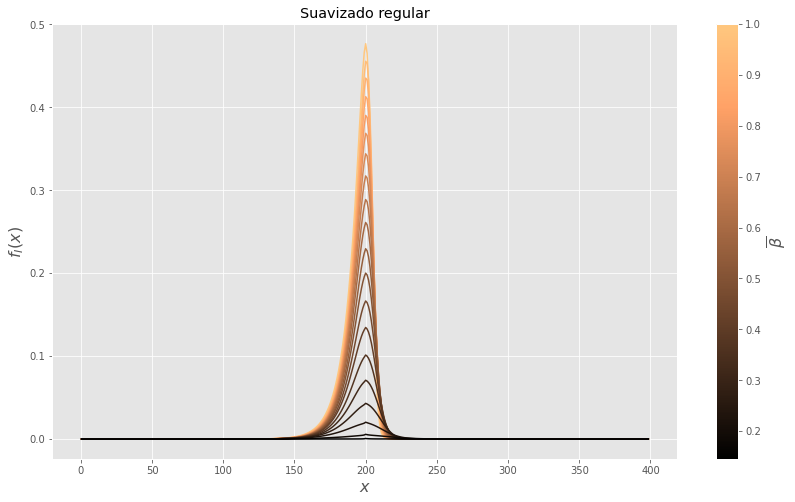

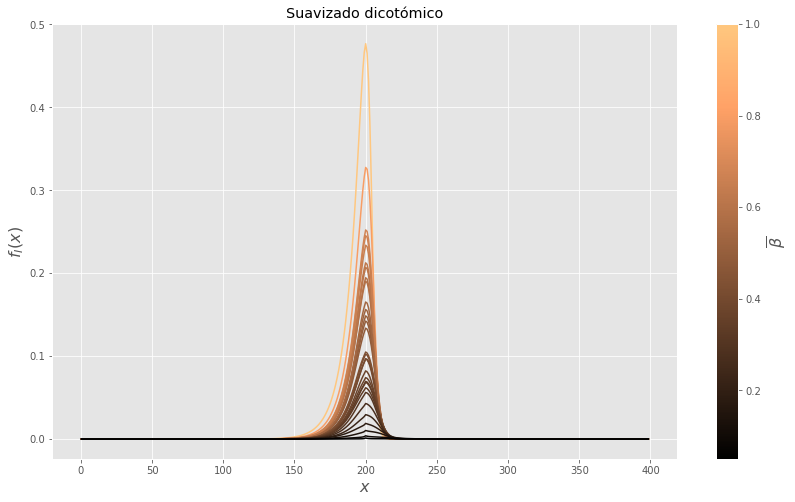

In [ ]:
fp_scan(p_vec[::5],1,flag='smoth',cbar=True)
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$f_I(x)$',fontsize=16)
plt.title('Suavizado regular')

fp_scan(p_vec[::5],1,flag='dic_smoth',cbar=True)
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$f_I(x)$',fontsize=16)
plt.title('Suavizado dicotómico')

fbeta_scan(p_vec[::5],1,flag='smoth',cbar=True)
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$f_I(x)$',fontsize=16)
plt.title('Suavizado regular')

fbeta_scan(p_vec_dic[::5],1,flag='dic_smoth',cbar=True)
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$f_I(x)$',fontsize=16)
plt.title('Suavizado dicotómico')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning:

divide by zero encountered in true_divide



Text(0.5, 1.0, 'Suavizado regular')

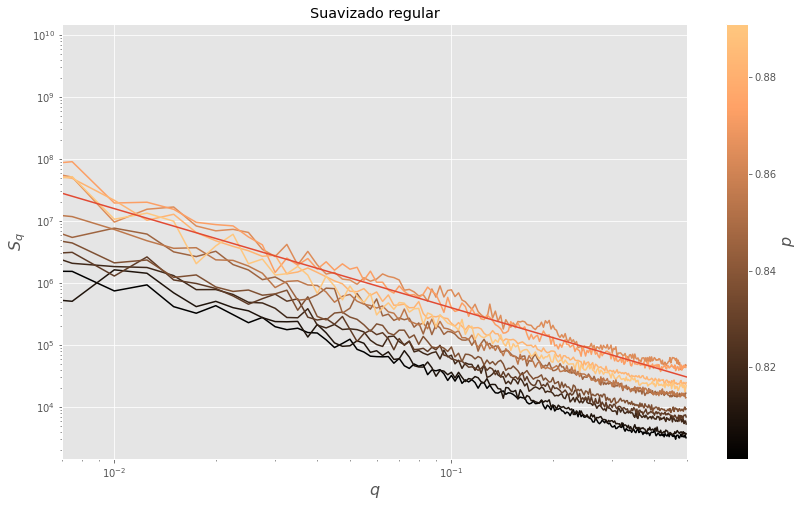

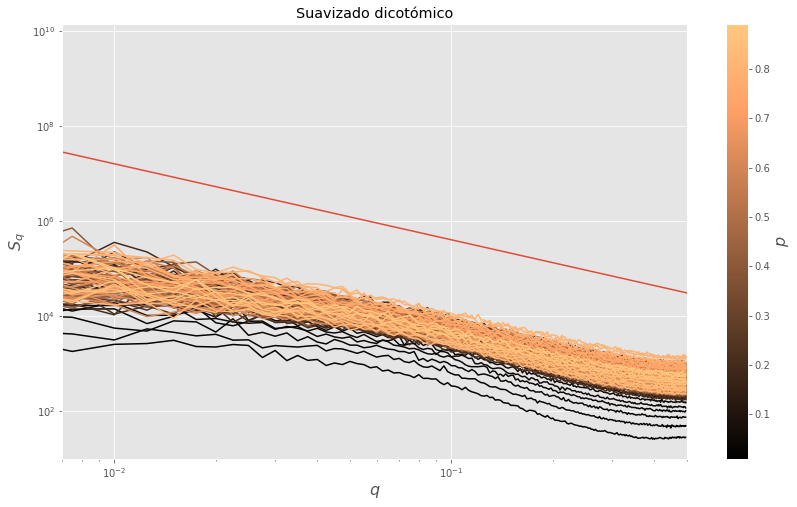

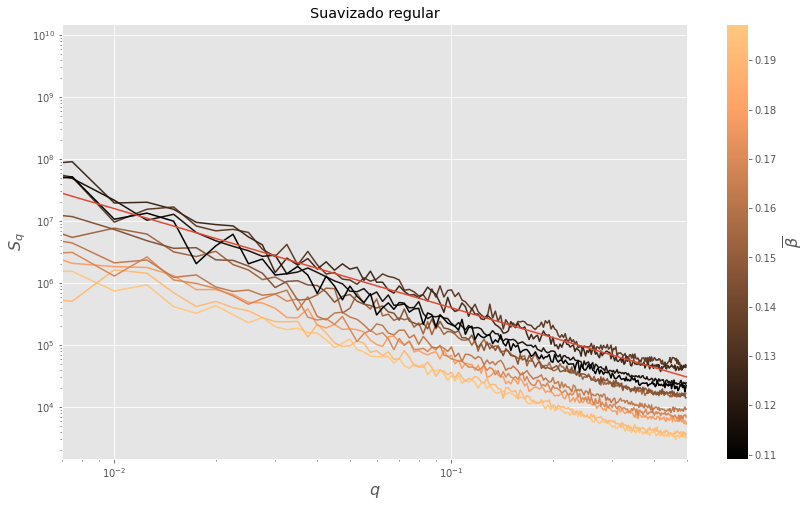

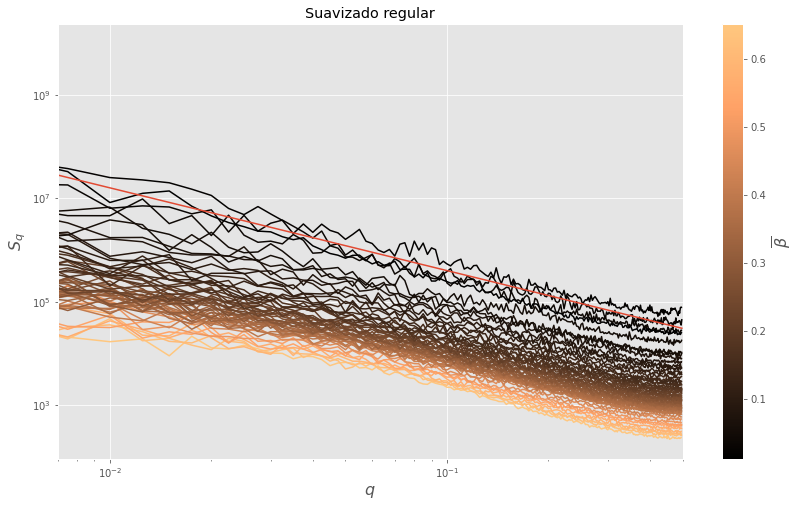

In [ ]:
fftp_scan(p_vec[p_vec>.8],1,flag='smoth')
plt.loglog(np.fft.fftfreq(400),10000/np.fft.fftfreq(400)**(1.6))
plt.xlabel('$q$',fontsize=16)
plt.ylabel('$S_{q}$',fontsize=16)
plt.title('Suavizado regular')

fftp_scan(p_vec[1:],1,flag='dic_smoth')
plt.loglog(np.fft.fftfreq(400),10000/np.fft.fftfreq(400)**(1.6))
plt.xlabel('$q$',fontsize=16)
plt.ylabel('$S_{q}$',fontsize=16)
plt.title('Suavizado dicotómico')

fftbeta_scan(p_vec[p_vec>.8],1,flag='smoth')
plt.loglog(np.fft.fftfreq(400),10000/np.fft.fftfreq(400)**(1.6))
plt.xlabel('$q$',fontsize=16)
plt.ylabel('$S_{q}$',fontsize=16)
plt.title('Suavizado regular')

fftbeta_scan(p_vec_dic[p_vec_dic>.8],1,flag='dic_smoth')
plt.loglog(np.fft.fftfreq(400),10000/np.fft.fftfreq(400)**(1.6))
plt.xlabel('$q$',fontsize=16)
plt.ylabel('$S_{q}$',fontsize=16)
plt.title('Suavizado dicotómico')

## Beta

Text(0, 0.5, 'beta_mean')

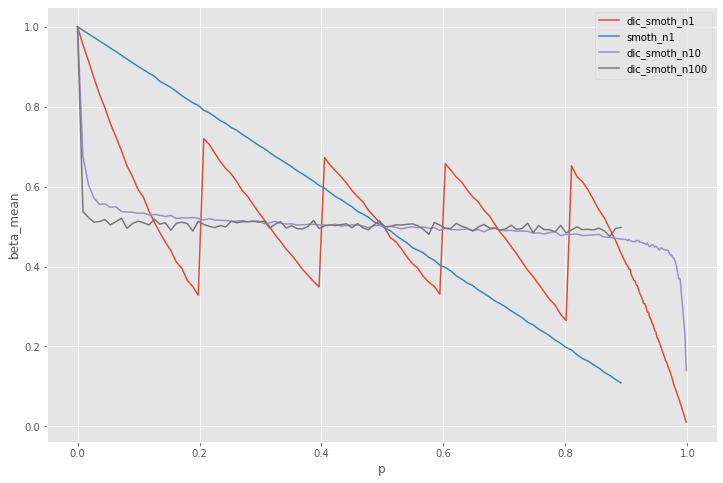

In [ ]:
mean1=np.array([])
mean2=np.array([])
mean3=np.array([])
mean4=np.array([])
for p in p_vec:
  beta2 = np.load('beta_1_'+str(p)+'_smoth_.npy')
  mean2 = np.append(mean2,np.mean(beta2))
  beta4 = np.load('beta_100_'+str(p)+'_dic_smoth_.npy')
  mean4 = np.append(mean4,np.mean(beta4))

mean1 = np.array([np.mean(np.load('beta_1_'+str(p)+'_dic_smoth_.npy')) for p in p_vec_dic])
mean3 = np.array([np.mean(np.load('beta_10_'+str(p)+'_dic_smoth_.npy')) for p in p_vec_dic])

plt.figure(figsize=(12,8))
plt.plot(p_vec_dic,mean1,label='dic_smoth_n1')
plt.plot(p_vec,mean2,label='smoth_n1')
plt.plot(p_vec_dic,mean3,label='dic_smoth_n10')
plt.plot(p_vec,mean4,label='dic_smoth_n100')
plt.legend()
plt.xlabel('p')
plt.ylabel('beta_mean')

In [ ]:
print(p_vec_dic)

[0.    0.009 0.018 0.027 0.036 0.045 0.054 0.063 0.072 0.081 0.09  0.099
 0.108 0.117 0.126 0.135 0.144 0.153 0.162 0.171 0.18  0.189 0.198 0.207
 0.216 0.225 0.234 0.243 0.252 0.261 0.27  0.279 0.288 0.297 0.306 0.315
 0.324 0.333 0.342 0.351 0.36  0.369 0.378 0.387 0.396 0.405 0.414 0.423
 0.432 0.441 0.45  0.459 0.468 0.477 0.486 0.495 0.504 0.513 0.522 0.531
 0.54  0.549 0.558 0.567 0.576 0.585 0.594 0.603 0.612 0.621 0.63  0.639
 0.648 0.657 0.666 0.675 0.684 0.693 0.702 0.711 0.72  0.729 0.738 0.747
 0.756 0.765 0.774 0.783 0.792 0.801 0.81  0.819 0.828 0.837 0.846 0.855
 0.864 0.873 0.882 0.891 0.9   0.902 0.904 0.906 0.908 0.91  0.912 0.914
 0.916 0.918 0.92  0.922 0.924 0.926 0.928 0.93  0.932 0.934 0.936 0.938
 0.94  0.942 0.944 0.946 0.948 0.95  0.952 0.954 0.956 0.958 0.96  0.962
 0.964 0.966 0.968 0.97  0.972 0.974 0.976 0.978 0.98  0.982 0.984 0.986
 0.988 0.99  0.992 0.994 0.996 0.998]


## Barridos en n

In [ ]:
def p_c(p_vec,n_vec,flag=''):
  c0=np.array([])
  c0_err=np.array([])
  pc=np.array([])
  pc_err=np.array([])
  alpha=np.array([])
  alpha_err=np.array([])
  for n in n_vec:
    c,c_err = cp_scan(p_vec,n,flag=flag)
    fit,cov = curve_fit(root,p_vec,c,sigma=c_err)
    c0 = np.append(c0,fit[0]); c0_err =np.append(c0_err,cov[0,0])
    pc = np.append(pc,fit[1]); pc_err =np.append(pc_err,cov[1,1])
    alpha = np.append(alpha,fit[2]); alpha_err =np.append(alpha_err,cov[2,2])
  return [c0,pc,alpha],[c0_err,pc_err,alpha_err]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in power



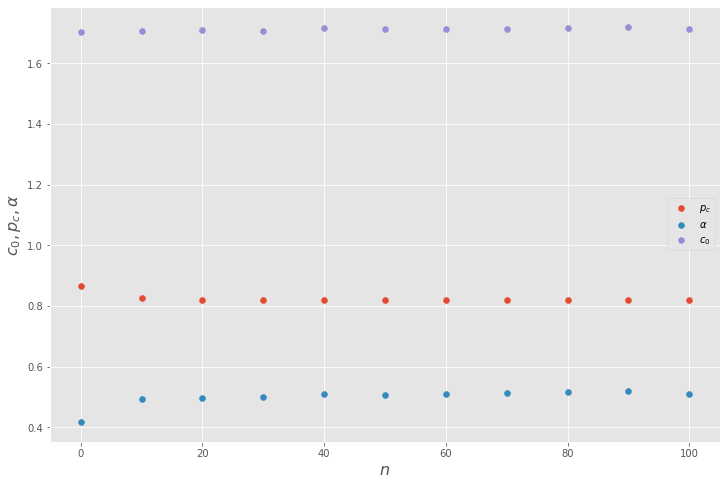

In [ ]:
n_vec = np.arange(0,110,10)
fits,errors = p_c(p_vec[p_vec<.82],n_vec,flag='smoth')
plt.figure(figsize=(12,8))
plt.scatter(n_vec,fits[1],label='$p_c$')
plt.scatter(n_vec,fits[2],label=r'$\alpha$')
plt.scatter(n_vec,fits[0],label='$c_0$')
plt.xlabel('$n$',fontsize=16)
plt.ylabel(r'$c_0,p_c,\alpha$',fontsize=16)
plt.legend()

## Imagenes para tesis


In [ ]:
X,Y,pos,Y_max,width,fft,q,f,beta,time = solver(t_max=500)

npX = cp.asnumpy(X)
npY = cp.asnumpy(Y)
nppos = cp.asnumpy(pos)
npY_max = cp.asnumpy(Y_max)
npwidth = cp.asnumpy(width)
npfft = cp.asnumpy(fft)
npq = cp.asnumpy(q)
npf = cp.asnumpy(f)
npbeta = cp.asnumpy(beta)
nptime = cp.asnumpy(time)

/usr/local/lib/python3.7/dist-packages/cupy/fft/_fft.py:152: UserWarning:

cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.



In [ ]:
#Imagen para tesis
sol = solver()
X = cp.asnumpy(sol[0])
f = cp.asnumpy(sol[7])

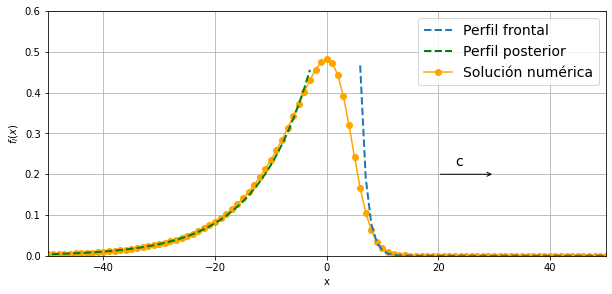

In [ ]:
S1 = np.mean(np.mean(X,axis=0)[100:400])
x = np.arange(-len(f)//2,len(f)//2)
fig,ax = plt.subplots(figsize=(10,4.5))

ax.plot(x[len(x)//2+6:],100*f_I_front(x[len(x)//2+6:]),'--',label='Perfil frontal',zorder=10,linewidth=2)
ax.plot(x[:len(x)//2-2],.62*f_I_back(x[:len(x)//2-2],S1=S1),'--',label='Perfil posterior',zorder=10,c='green',linewidth=2)
ax.plot(x,f,'-o',label=r'Solución numérica',c='orange')
plt.annotate(s='', xy=(30,.2), xytext=(20,.2), arrowprops=dict(arrowstyle='->'))
plt.text(23,.22,'c',fontsize=14)
plt.xlabel('x')
plt.ylabel(r'$f_I(x)$')
plt.xlim(-50,50)
plt.ylim(0,.6)
plt.grid()
plt.legend(fontsize=14)
plt.show()

fig.savefig('/content/drive/MyDrive/Tesis/ibtesis/figs/f_I(x)_hom.pdf',bbox_inches='tight')


In [ ]:
#Imagen para tesis
sol = solver()
ucm = cp.asnumpy(sol[2])
t = cp.asnumpy(sol[9])
sol = solver(gamma0=0.4)
ucm1 = cp.asnumpy(sol[2])
t1 = cp.asnumpy(sol[9])
sol = solver(gamma0=0.6)
ucm2 = cp.asnumpy(sol[2])
t2 = cp.asnumpy(sol[9])
sol = solver(gamma0=0.8)
ucm3 = cp.asnumpy(sol[2])
t3 = cp.asnumpy(sol[9])
sol = solver(gamma0=1.)
ucm4 = cp.asnumpy(sol[2])
t4 = cp.asnumpy(sol[9])




1.704870214326477
2.032869214931694e-09
1.491257757975636
1.5166933964502389e-09
1.2296564495102895
1.021192172442584e-09
0.8772323771367161
5.767987292018603e-10
0.030102980567378923
4.021397731908114e-10


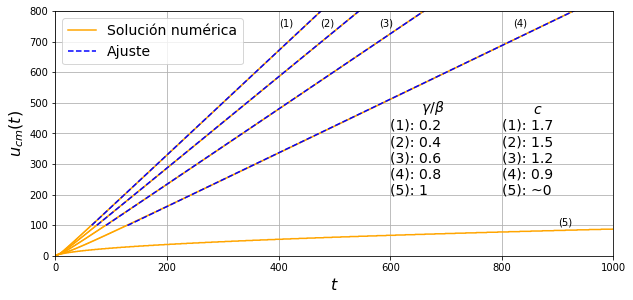

In [ ]:
th=100
fig,ax = plt.subplots(figsize=(10,4.5))
fit,cov = curve_fit(lineal,t[ucm>th],ucm[ucm>th])
fit1,cov1 = curve_fit(lineal,t1[ucm1>th],ucm1[ucm1>th])
fit2,cov2 = curve_fit(lineal,t2[ucm2>th],ucm2[ucm2>th])
fit3,cov3 = curve_fit(lineal,t3[ucm3>th],ucm3[ucm3>th])

ax.plot(t,ucm,'orange',label='Solución numérica')
ax.plot(t[ucm>th],lineal(t[ucm>th],*fit),'--',c='blue',label='Ajuste')
ax.plot(t1,ucm1,'orange')
ax.plot(t1[ucm1>th],lineal(t1[ucm1>th],*fit1),'--',c='blue')
ax.plot(t2,ucm2,'orange')
ax.plot(t2[ucm2>th],lineal(t2[ucm2>th],*fit2),'--',c='blue')
ax.plot(t3,ucm3,'orange')
ax.plot(t3[ucm3>th],lineal(t3[ucm3>th],*fit3),'--',c='blue')
ax.plot(t4,ucm4,'orange')

print(fit[0])
print(cov[0,0])
print(fit1[0])
print(cov1[0,0])
print(fit2[0])
print(cov2[0,0])
print(fit3[0])
print(cov3[0,0])


ax.text(400,750,'(1)')
ax.text(475,750,'(2)')
ax.text(580,750,'(3)')
ax.text(900,100,'(5)')
ax.text(820,750,'(4)')
ax.text(600,200,r'       $\gamma/\beta$'+'\n(1): 0.2\n(2): 0.4\n(3): 0.6\n(4): 0.8\n(5): 1',fontsize=14)
ax.text(800,200,r'       $c$'+'\n(1): 1.7\n(2): 1.5\n(3): 1.2\n(4): 0.9\n(5): ~0',fontsize=14)
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$u_{cm}(t)$',fontsize=16)
plt.xlim(0,1000)
plt.ylim(0,800)
plt.grid()
plt.legend(fontsize=14)
plt.show()
fig.savefig('/content/drive/MyDrive/Tesis/ibtesis/figs/u_cm(t).pdf',bbox_inches='tight')



In [ ]:
#Imagen para tesis
Y1 = cp.asnumpy(solver(t_max=200)[1])
Y2 = cp.asnumpy(solver(t_max=400)[1])
Y3 = cp.asnumpy(solver(t_max=600)[1])
Y4 = cp.asnumpy(solver(t_max=800)[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



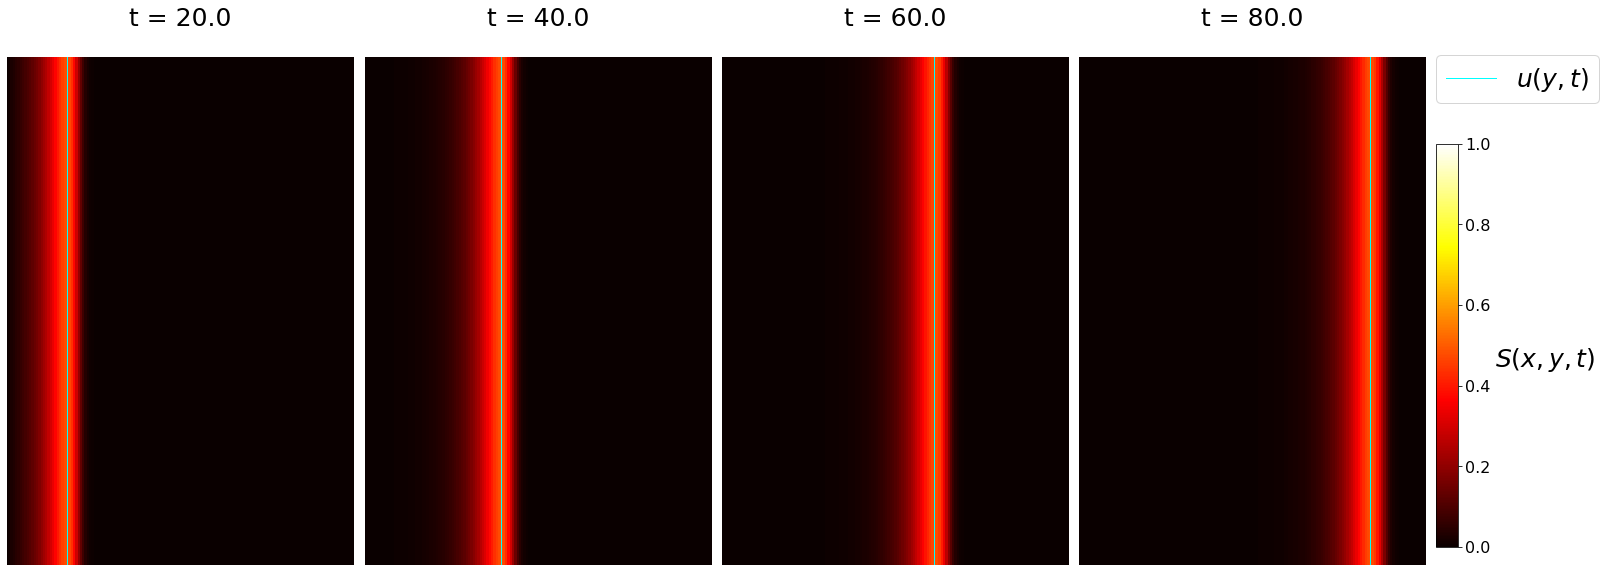

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20,8))
cmap = plt.get_cmap('hot')

im = ax[0].matshow(Y1,cmap=cmap,clim=(0,1))
im2 = ax[0].plot(u(Y1),np.arange(1024),c='cyan',linewidth=1,label=r'$u(y,t)$')
ax[0].set_aspect('auto')
ax[0].axis('off')
ax[0].set_xlim(0,150)
ax[0].set_title('t = '+ str(200*.1),fontsize=25)
ax[1].matshow(Y2,cmap=cmap,clim=(0,1))
ax[1].plot(u(Y2),np.arange(1024),c='cyan',linewidth=1)
ax[1].set_aspect('auto')
ax[1].axis('off')
ax[1].set_xlim(0,150)
ax[1].set_title('t = '+ str(400*.1),fontsize=25)
ax[2].matshow(Y3,cmap=cmap,clim=(0,1))
ax[2].plot(u(Y3),np.arange(1024),c='cyan',linewidth=1)
ax[2].set_aspect('auto')
ax[2].axis('off')
ax[2].set_xlim(0,150)
ax[2].set_title('t = '+ str(600*.1),fontsize=25)
ax[3].matshow(Y4,cmap=cmap,clim=(0,1))
ax[3].plot(u(Y4),np.arange(1024),c='cyan',linewidth=1)
ax[3].set_aspect('auto')
ax[3].axis('off')
ax[3].set_xlim(0,150)
ax[3].set_title('t = '+ str(800*.1),fontsize=25)

cb_ax = fig.add_axes([1,.05,.015,.7])
cbar = plt.colorbar(im,cax=cb_ax)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$S(x,y,t)$',fontsize=25,rotation=0,labelpad=55)
plt.legend(im2,[r'$u(y,t)$'],loc=(0,1.1),fontsize=25)
fig.tight_layout()
plt.show()

fig.savefig('/content/drive/MyDrive/Tesis/ibtesis/figs/hom_case_tevol.pdf',bbox_inches='tight')


In [ ]:
#Imagen para tesis
Y1 = cp.asnumpy(solver(t_max=200,p_beta=.3)[1])
Y2 = cp.asnumpy(solver(t_max=400,p_beta=.3)[1])
Y3 = cp.asnumpy(solver(t_max=600,p_beta=.3)[1])
Y4 = cp.asnumpy(solver(t_max=800,p_beta=.3)[1])

/usr/local/lib/python3.7/dist-packages/cupy/fft/_fft.py:152: UserWarning:

cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



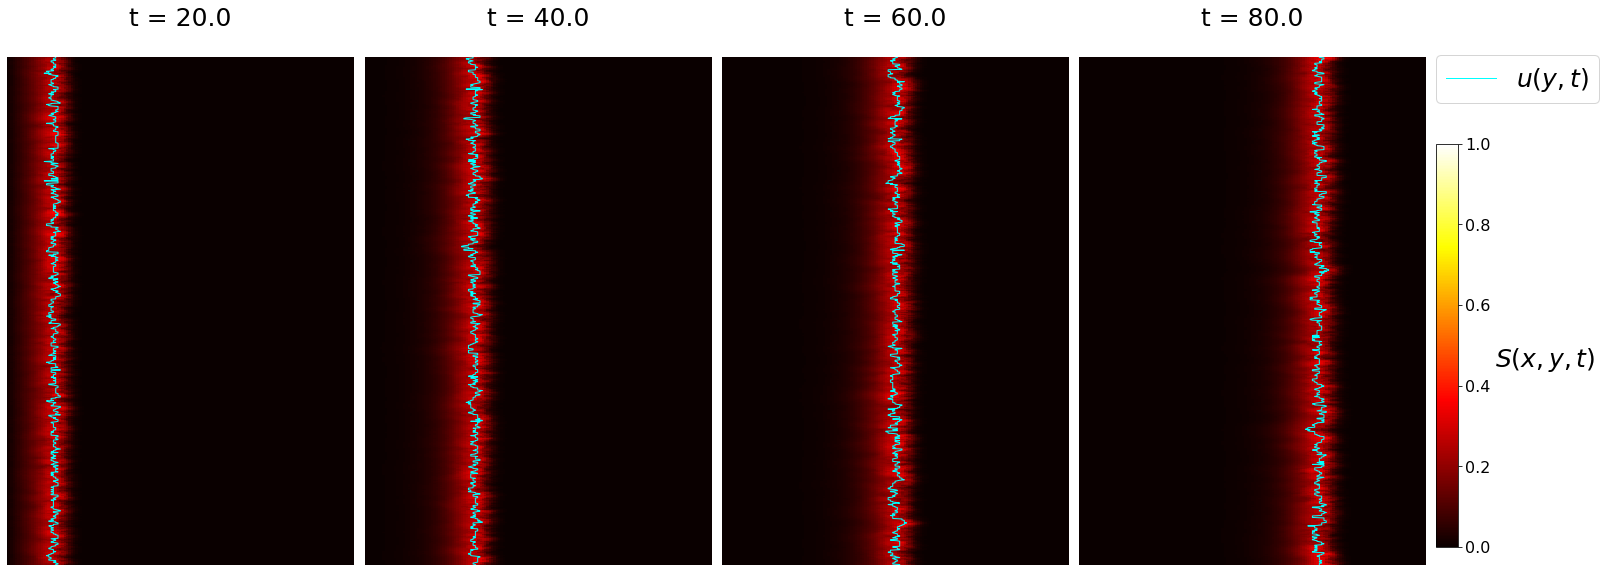

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20,8))
cmap = plt.get_cmap('hot')

im = ax[0].matshow(Y1,cmap=cmap,clim=(0,1))
im2 = ax[0].plot(u(Y1),np.arange(1024),c='cyan',linewidth=1,label=r'$u(y,t)$')
ax[0].set_aspect('auto')
ax[0].axis('off')
ax[0].set_xlim(0,150)
ax[0].set_title('t = '+ str(200*.1),fontsize=25)
ax[1].matshow(Y2,cmap=cmap,clim=(0,1))
ax[1].plot(u(Y2),np.arange(1024),c='cyan',linewidth=1)
ax[1].set_aspect('auto')
ax[1].axis('off')
ax[1].set_xlim(0,150)
ax[1].set_title('t = '+ str(400*.1),fontsize=25)
ax[2].matshow(Y3,cmap=cmap,clim=(0,1))
ax[2].plot(u(Y3),np.arange(1024),c='cyan',linewidth=1)
ax[2].set_aspect('auto')
ax[2].axis('off')
ax[2].set_xlim(0,150)
ax[2].set_title('t = '+ str(600*.1),fontsize=25)
ax[3].matshow(Y4,cmap=cmap,clim=(0,1))
ax[3].plot(u(Y4),np.arange(1024),c='cyan',linewidth=1)
ax[3].set_aspect('auto')
ax[3].axis('off')
ax[3].set_xlim(0,150)
ax[3].set_title('t = '+ str(800*.1),fontsize=25)

cb_ax = fig.add_axes([1,.05,.015,.7])
cbar = plt.colorbar(im,cax=cb_ax)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$S(x,y,t)$',fontsize=25,rotation=0,labelpad=55)
plt.legend(im2,[r'$u(y,t)$'],loc=(0,1.1),fontsize=25)
fig.tight_layout()
plt.show()

fig.savefig('/content/drive/MyDrive/Tesis/ibtesis/figs/hetal_case_tevol.pdf',bbox_inches='tight')

In [ ]:
p_aux = np.arange(0,.8,.8/50)
beta = (1-p_aux)
chom = np.array([])
Ihom = np.array([])

for b in beta:
  sol = solver(beta0=b)
  t = cp.asnumpy(sol[-1])
  ucm = cp.asnumpy(sol[2])
  I_max = cp.asnumpy(cp.mean(sol[3][ucm>400]))
  fit,cov = curve_fit(lineal,t,ucm)
  chom = np.append(chom,fit[0])
  Ihom = np.append(Ihom,I_max)



In [ ]:
p_aux2 = np.arange(0,.6,.6/50)
beta = (1-p_aux2)
chom2 = np.array([])
Ihom2 = np.array([])

for b in beta:
  sol = solver(beta0=b,gamma0=.4)
  t = cp.asnumpy(sol[-1])
  ucm = cp.asnumpy(sol[2])
  I_max = cp.asnumpy(cp.mean(sol[3]))
  fit,cov = curve_fit(lineal,t,ucm)
  chom2 = np.append(chom2,fit[0])
  Ihom2 = np.append(Ihom,I_max)


In [ ]:
np.save('chom_gamma.2',chom)
np.save('Ihom_gamma.2',Ihom)
np.save('chom_gamma.4',chom2)
np.save('Ihom_gamma.4',Ihom2)

In [ ]:
chom=np.load('chom_gamma.2.npy')
Ihom=np.load('Ihom_gamma.2.npy')
chom2=np.load('chom_gamma.4.npy')
Ihom2=np.load('Ihom_gamma.4.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in power

/usr/local/lib/python3.7/dist-packages/ipykernel_launche

[2.06089304 0.92466591 0.60841945]
[1.80474442 0.79901132 0.734055  ]
[1.70643994 0.79636932 0.47784762]
[1.49125811 0.5975788  0.48431787]
[0.91190195 0.89960455 1.9346487 ]
[0.34280708 0.75281934 2.11659419]


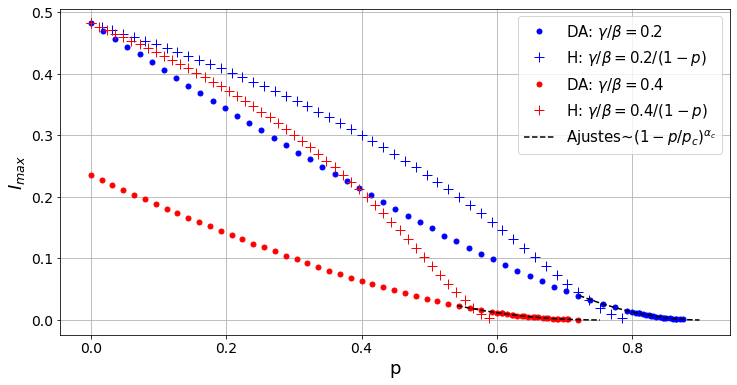

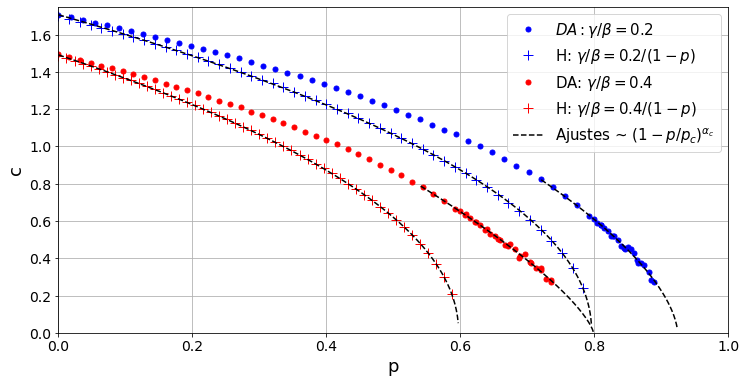

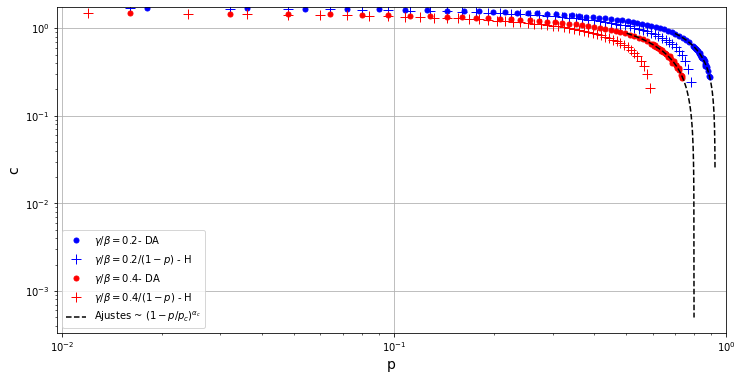

In [ ]:
pi = 0;pf = .9;n0 = 50
p_vec1 = np.arange(pi,pf,(pf-pi)/n0)
pi = .9;pf = .95;n0 = 20
p_vec2 = np.arange(pi,pf,(pf-pi)/n0)
pi = .8;pf = .9;n0 = 20
p_vec3 = np.arange(pi,pf,(pf-pi)/n0)
pi = 0;pf = .8;n0 = 50
p_vec4 = np.arange(pi,pf,(pf-pi)/n0)
pi = .6;pf = .75;n0 = 20
p_vec5 = np.arange(pi,pf,(pf-pi)/n0)
p_vec6 = np.append(p_vec4,p_vec5)
p_vec6 = np.append(p_vec6,np.arange(.75,.8,.05/10))
p_vec = np.append(p_vec1,[p_vec2,p_vec3])
p_vec_aux = np.append(p_vec1,p_vec2)

p_aux = np.arange(0,.8,.8/50)
p_aux2 = np.arange(0,.6,.6/50)

pz = np.arange(0,1,.001)

pc = .9*.8
pc2 = .9*.6

plt.figure(figsize=(12,6))
pi,I = Yp_scan(p_vec,0)
pi2,I2 = Yp_scan(p_vec6,0,flag='gamma.4')
fitI,covI = curve_fit(root,pi[pi>pc],I[pi>pc])
fitI2,covI2 = curve_fit(root,pi2[pi2>pc2],I2[pi2>pc2])

#I_max graph
plt.plot(pi,I,'o',markersize=5,label=r'DA: $\gamma/\beta=0.2$',c='blue')
plt.plot(p_aux,Ihom,'+',markersize=10,label=r'H: $\gamma/\beta=0.2/(1-p)$',c='blue')
plt.plot(pi2,I2,'o',markersize=5,label=r'DA: $\gamma/\beta=0.4$',c='red')
plt.plot(p_aux2,Ihom2[:-1],'+',markersize=10,label=r'H: $\gamma/\beta=0.4/(1-p)$',c='red')

plt.plot(pz[pz>pc],root(pz[pz>pc],*fitI),'--',c='black',label=r'Ajustes~$(1-p/p_c)^{\alpha_c}$')
plt.plot(pz[pz>pc2],root(pz[pz>pc2],*fitI2),'--',c='black')

plt.ylabel('$I_{max}$',fontsize=18)
plt.xlabel('p',fontsize=18)
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.savefig('/content/drive/MyDrive/Tesis/ibtesis/figs/amplitud_p.pdf')



#c graph
p,c,cerr = cp_scan(p_vec,0)
p1,c1,cerr1 = cp_scan(p_vec6,0,flag='gamma.4')
fit,cov = curve_fit(root,p[p>pc],c[p>pc])
fit1,cov1 = curve_fit(root,p1[p1>pc2],c1[p1>pc2])
fit2,cov2 = curve_fit(root,p_aux,chom)
fit3,cov3 = curve_fit(root,p_aux2,chom2,p0=[1.7,.6,.5])

plt.figure(figsize=(12,6))
plt.plot(p,c,'o',markersize=5,label=r'$DA: \gamma/\beta=0.2$',c='blue')
plt.plot(p_aux,chom,'+',markersize=10,label=r'H: $\gamma/\beta=0.2/(1-p)$',c='blue')
plt.plot(p1,c1,'o',markersize=5,label=r'DA: $\gamma/\beta=0.4$',c='red')
plt.plot(p_aux2,chom2,'+',markersize=10,label=r'H: $\gamma/\beta=0.4/(1-p)$',c='red')
plt.plot(pz[pz>pc],root(pz[pz>pc],*fit),'--',c='black',label=r'Ajustes ~ $(1-p/p_c)^{\alpha_c}$')
plt.plot(pz[pz>pc2],root(pz[pz>pc2],*fit1),'--',c='black')
plt.plot(pz,root(pz,*fit2),'--',c='black')
plt.plot(pz,root(pz,*fit3),'--',c='black')
plt.xlabel('p',fontsize=18)
plt.ylabel('c',fontsize=18)
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1.75)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=15)
plt.savefig('/content/drive/MyDrive/Tesis/ibtesis/figs/velocidad_p.pdf')


plt.figure(figsize=(12,6))
plt.loglog(p,c,'o',markersize=5,label=r'$\gamma/\beta=0.2$- DA',c='blue')
plt.loglog(p_aux,chom,'+',markersize=10,label=r'$\gamma/\beta=0.2/(1-p)$ - H',c='blue')
plt.loglog(p1,c1,'o',markersize=5,label=r'$\gamma/\beta=0.4$- DA',c='red')
plt.loglog(p_aux2,chom2,'+',markersize=10,label=r'$\gamma/\beta=0.4/(1-p)$ - H',c='red')
plt.loglog(pz[pz>.7],root(pz[pz>.7],*fit),'--',c='black',label=r'Ajustes ~ $(1-p/p_c)^{\alpha_c}$')
plt.loglog(pz[pz>.5],root(pz[pz>.5],*fit1),'--',c='black')
plt.xlabel('p',fontsize=14)
plt.ylabel('c',fontsize=14)
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1.75)
plt.legend()

print(fit)
print(fit1)
print(fit2)
print(fit3)
print(fitI)
print(fitI2)

plt.show()

In [ ]:
#Imagen para tesis

Y1 = cp.asnumpy(solver(t_max=200,p_beta=.3,beta_type='smoth',smoth_steps=1)[1])
Y2 = cp.asnumpy(solver(t_max=400,p_beta=.3,beta_type='smoth',smoth_steps=1)[1])
Y3 = cp.asnumpy(solver(t_max=600,p_beta=.3,beta_type='smoth',smoth_steps=1)[1])
Y4 = cp.asnumpy(solver(t_max=800,p_beta=.3,beta_type='smoth',smoth_steps=1)[1])

/usr/local/lib/python3.7/dist-packages/cupy/fft/_fft.py:152: UserWarning:

cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



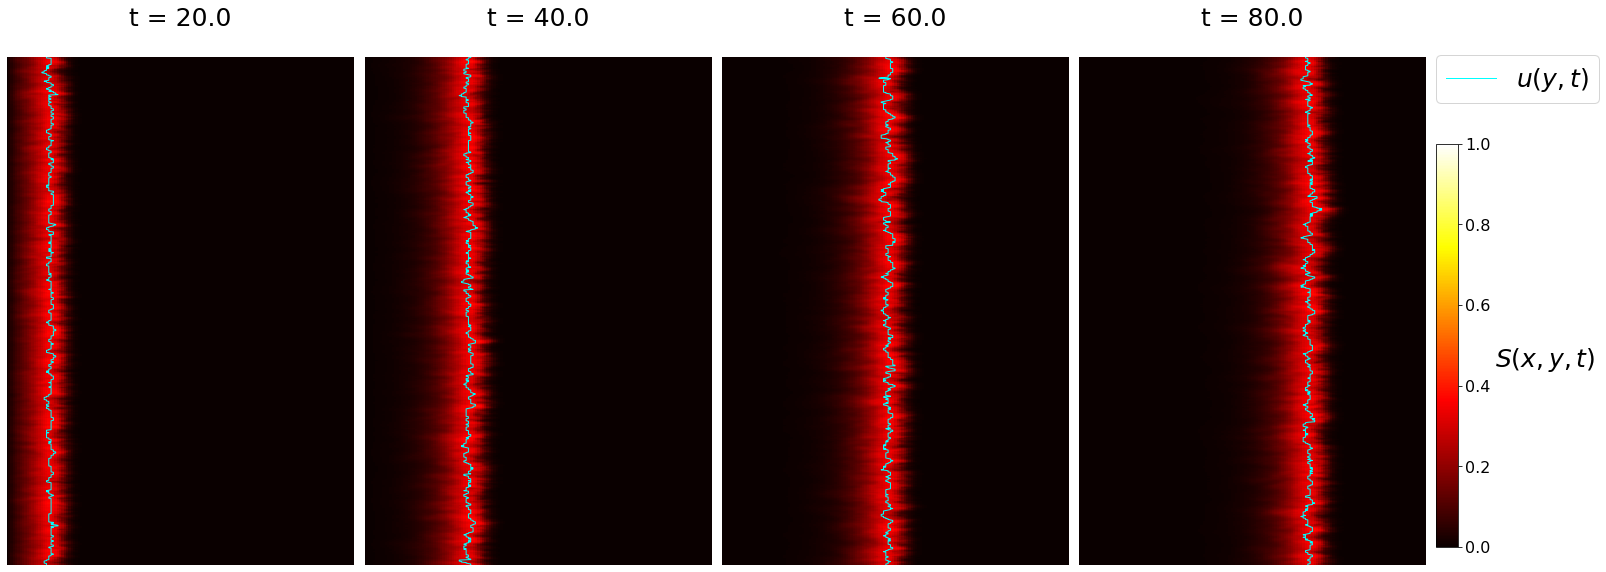

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20,8))
cmap = plt.get_cmap('hot')

im = ax[0].matshow(Y1,cmap=cmap,clim=(0,1))
im2 = ax[0].plot(u(Y1),np.arange(1024),c='cyan',linewidth=1,label=r'$u(y,t)$')
ax[0].set_aspect('auto')
ax[0].axis('off')
ax[0].set_xlim(0,150)
ax[0].set_title('t = '+ str(200*.1),fontsize=25)
ax[1].matshow(Y2,cmap=cmap,clim=(0,1))
ax[1].plot(u(Y2),np.arange(1024),c='cyan',linewidth=1)
ax[1].set_aspect('auto')
ax[1].axis('off')
ax[1].set_xlim(0,150)
ax[1].set_title('t = '+ str(400*.1),fontsize=25)
ax[2].matshow(Y3,cmap=cmap,clim=(0,1))
ax[2].plot(u(Y3),np.arange(1024),c='cyan',linewidth=1)
ax[2].set_aspect('auto')
ax[2].axis('off')
ax[2].set_xlim(0,150)
ax[2].set_title('t = '+ str(600*.1),fontsize=25)
ax[3].matshow(Y4,cmap=cmap,clim=(0,1))
ax[3].plot(u(Y4),np.arange(1024),c='cyan',linewidth=1)
ax[3].set_aspect('auto')
ax[3].axis('off')
ax[3].set_xlim(0,150)
ax[3].set_title('t = '+ str(800*.1),fontsize=25)

cb_ax = fig.add_axes([1,.05,.015,.7])
cbar = plt.colorbar(im,cax=cb_ax)
cbar.set_label(r'$S(x,y,t)$',fontsize=25,rotation=0,labelpad=55)
cbar.ax.tick_params(labelsize=16)
plt.legend(im2,[r'$u(y,t)$'],loc=(0,1.1),fontsize=25)
fig.tight_layout()
plt.show()

fig.savefig('/content/drive/MyDrive/Tesis/ibtesis/figs/suavizada_tevol.pdf',bbox_inches='tight')

In [ ]:
#Imagen para tesis
Y1 = cp.asnumpy(solver(t_max=200,p_beta=.3,beta_type='dic_smoth',smoth_steps=1)[1])
Y2 = cp.asnumpy(solver(t_max=400,p_beta=.3,beta_type='dic_smoth',smoth_steps=1)[1])
Y3 = cp.asnumpy(solver(t_max=600,p_beta=.3,beta_type='dic_smoth',smoth_steps=1)[1])
Y4 = cp.asnumpy(solver(t_max=800,p_beta=.3,beta_type='dic_smoth',smoth_steps=1)[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



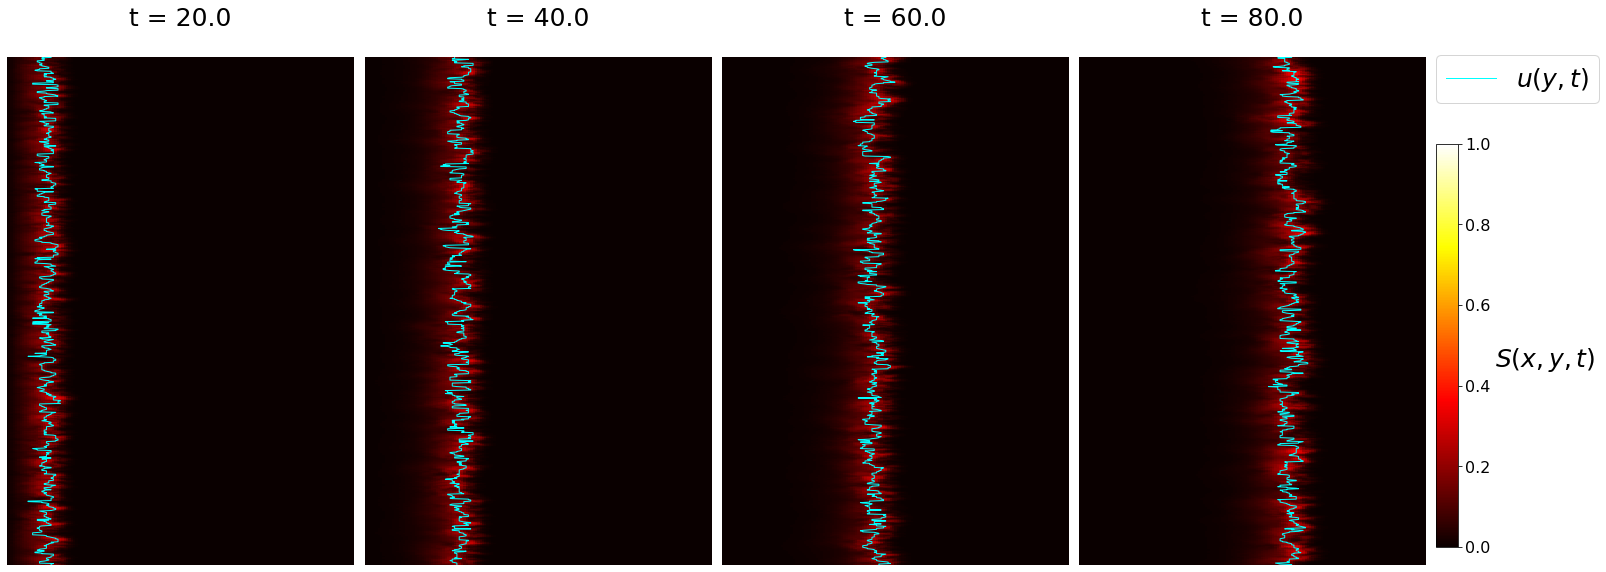

In [ ]:
fig,ax = plt.subplots(1,4,figsize=(20,8))
cmap = plt.get_cmap('hot')

im = ax[0].matshow(Y1,cmap=cmap,clim=(0,1))
im2 = ax[0].plot(u(Y1),np.arange(1024),c='cyan',linewidth=1,label=r'$u(y,t)$')
ax[0].set_aspect('auto')
ax[0].axis('off')
ax[0].set_xlim(0,150)
ax[0].set_title('t = '+ str(200*.1),fontsize=25)
ax[1].matshow(Y2,cmap=cmap,clim=(0,1))
ax[1].plot(u(Y2),np.arange(1024),c='cyan',linewidth=1)
ax[1].set_aspect('auto')
ax[1].axis('off')
ax[1].set_xlim(0,150)
ax[1].set_title('t = '+ str(400*.1),fontsize=25)
ax[2].matshow(Y3,cmap=cmap,clim=(0,1))
ax[2].plot(u(Y3),np.arange(1024),c='cyan',linewidth=1)
ax[2].set_aspect('auto')
ax[2].axis('off')
ax[2].set_xlim(0,150)
ax[2].set_title('t = '+ str(600*.1),fontsize=25)
ax[3].matshow(Y4,cmap=cmap,clim=(0,1))
ax[3].plot(u(Y4),np.arange(1024),c='cyan',linewidth=1)
ax[3].set_aspect('auto')
ax[3].axis('off')
ax[3].set_xlim(0,150)
ax[3].set_title('t = '+ str(800*.1),fontsize=25)

cb_ax = fig.add_axes([1,.05,.015,.7])
cbar = plt.colorbar(im,cax=cb_ax)
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r'$S(x,y,t)$',fontsize=25,rotation=0,labelpad=55)
plt.legend(im2,[r'$u(y,t)$'],loc=(0,1.1),fontsize=25)
fig.tight_layout()
plt.show()

fig.savefig('/content/drive/MyDrive/Tesis/ibtesis/figs/suavizada_dic_tevol.pdf',bbox_inches='tight')

In [ ]:
sol = solver(p_beta=.3)
ucm0 = cp.asnumpy(sol[2])
time0 = cp.asnumpy(sol[-1])
sol = solver(p_beta=.3,beta_type='smoth',smoth_steps=1)
ucm1 = cp.asnumpy(sol[2])
time1 = cp.asnumpy(sol[-1]) 
sol = solver(p_beta=.3,beta_type='dic_smoth',smoth_steps=1)
ucm2 = cp.asnumpy(sol[2])
time2 = cp.asnumpy(sol[-1])
sol = solver(beta0 = .7)
ucm3 = cp.asnumpy(sol[2])
time3 = cp.asnumpy(sol[-1])

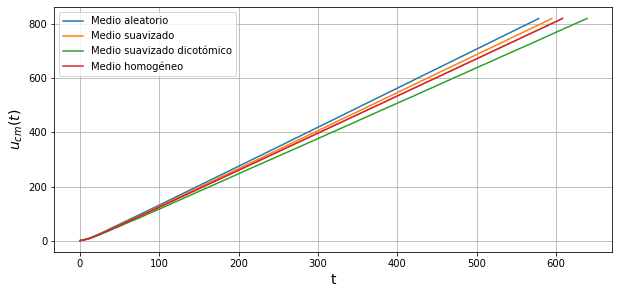

In [ ]:
plt.figure(figsize=(10,4.5))
plt.plot(time0,ucm0,label='Medio dicotómico')
plt.plot(time1,ucm1,label ='Medio suavizado')
plt.plot(time2,ucm2,label = 'Medio suavizado dicotómico')
plt.plot(time3,ucm3,label ='Medio homogéneo')

plt.legend()
plt.xlabel('t',fontsize=14)
plt.ylabel('$u_{cm}(t)$',fontsize=14)
plt.grid()

## Comparación de velocidad

In [ ]:
import time

def cpu_solver(L=200,N=1,nu=0.,mu=0.,Dx=0,Dy=1,beta=1.,gamma=.2,tstep=.1,t_max = 100):
  
  def fX(X,Y,params):
    nu,beta,mu,N,Dx = params
    X0,X1,X2,X3,X4 = X
    return nu - beta*X0*Y/N-mu*X0+Dx*(X1+X2+X3+X4-4*X0)
  def fY(X,Y,params):
      beta,N,gamma,mu,Dy = params
      Y0,Y1,Y2,Y3,Y4 = Y
      return beta*X*Y0/N-(gamma+mu)*Y0+Dy*(Y1+Y2+Y3+Y4-4*Y0)
  
  paramsX = [nu,beta,mu,N,Dx]
  paramsY = [beta,N,gamma,mu,Dy]

  #Condición inicial
  X = np.ones((L,L))
  Y = np.zeros((L,L))
  X[:,1] = np.zeros_like(X[:,1]) 
  Y[:,1] = np.ones_like(Y[:,1])
  X0 = X
  Y0 = Y

  ti=time.time()
  for t in range(t_max):
    for i in np.arange(L*L):
        x = i % L
        y = int(i/L)

        X_vec = [X0[y,x],X0[y,(x+1)%L],X0[y,x-1],X0[(y+1)%L,x],X0[y-1,x]]
        Y_vec = [Y0[y,x],Y0[y,(x+1)%L],Y0[y,x-1],Y0[(y+1)%L,x],Y0[y-1,x]]

        X[y,x] = X0[y,x] + tstep*fX(X_vec,Y_vec[0],paramsX)
        Y[y,x] = Y0[y,x] + tstep*fY(X_vec[0],Y_vec,paramsY)

        X[:,0] = 0; X[:,-1] = 0; Y[:,0] = 0; Y[:,-1] = 0;
        X0 = X
        Y0 = Y
    tf = time.time()
  return X,Y,tf-ti

In [ ]:
import time

def gpu_solver(L=200,N=1,nu=0.,mu=0.,Dx=0,Dy=1,beta0=1.,gamma0=.2,p_beta=0,p_gamma=0,tstep=.1,smoth_steps=0,beta_type='',t_max = 100):

  def line_infection(x):
    X[:,x] = cp.zeros_like(X[:,x])
    Y[:,x] = cp.ones_like(Y[:,x])

  def rigid_x():
    X[:,0] = X[:,-1] = Y[:,0] = Y[:,-1] = 0
  
  def dic_matrix(x0,x1,p,Lx,Ly):
    return cp.random.choice([x0,x1],size=(L,L),p = [p,1-p])

  # Heterogeneidad
  beta = dic_matrix(0,beta0,p_beta,L,L)
  gamma = dic_matrix(0,gamma0,p_gamma,L,L)
  params = cp.array([N,nu,mu,Dx,Dy])

  # Condición inicial
  X = cp.ones((L,L))
  Y = cp.zeros((L,L))
  line_infection(1)

  fX = cp.zeros((L,L))
  fY = cp.zeros((L,L))

  ti = time.perf_counter()
  for t in range(t_max):
    
    forces(X,Y,params,beta,gamma,L,fX,fY)
    X = X + tstep*fX
    Y = Y + tstep*fY 
 
    #Bordes rígidos
    rigid_x()
    #rigid_y()
  tf = time.perf_counter()

  return  cp.asnumpy(X),cp.asnumpy(Y),tf-ti

In [ ]:
S_cpu,I_cpu,dt_cpu = cpu_solver(L=1024,t_max=10)
plt.imshow(I)
plt.show()

 30%|███       | 3/10 [02:22<05:33, 47.59s/it]


KeyboardInterrupt: ignored

100%|██████████| 500/500 [00:00<00:00, 5186.21it/s]


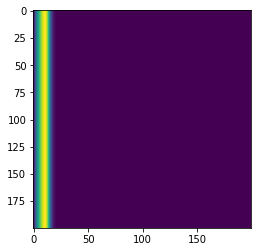

In [ ]:
S_gpu,I_gpu,dt_gpu = gpu_solver(L=10,t_max=500)
plt.imshow(I)
plt.show()

In [ ]:
Ls = np.arange(8,2048,10)
gpu_t = np.array([])

for l in tqdm(Ls):
  _,_,gpu_dt = gpu_solver(L=l,t_max=1000)
  gpu_t = np.append(gpu_t,gpu_dt)

np.save('gpu_t',gpu_t)
np.save('gpu_L',Ls)

100%|██████████| 204/204 [04:48<00:00,  1.41s/it]


In [ ]:
Ls = np.arange(5,100,5)
cpu_t = np.array([])

for l in tqdm(Ls):
  _,_,cpu_dt = cpu_solver(L=l)
  cpu_t = np.append(cpu_t,cpu_dt)
  
np.save('cpu_t',cpu_t)
np.save('cpu_L',Ls)

100%|██████████| 19/19 [01:28<00:00,  4.67s/it]


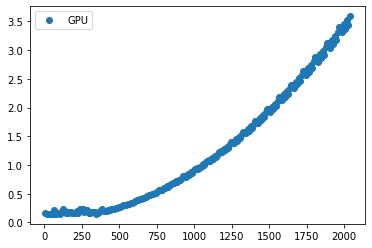

In [ ]:
plt.plot(Ls,gpu_t,'o',label='GPU')
#plt.yscale('log')
#plt.xlim(0,200)
plt.legend()